# Sentiment Analysis
1. Import Libraries
2. Load Data
3. Functions Definition
3. Summarize the Dataset
4. Data Visualization
5. Data Preparation
6. Evaluate Algorithms
7. Make Predictions

## 1. Import Libraries

In [1]:
#Install packages using pip
!pip install graphviz
!pip install beautifulsoup4
!pip install --upgrade -q gspread
!pip install PyDrive

    100% |████████████████████████████████| 993kB 5.8MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [2]:
#Import all necessary libraries
%matplotlib inline
import re
import sys
import gspread
import datetime
import itertools
import unicodedata
import xgboost as xgb 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from bs4 import BeautifulSoup
from google.colab import auth
from google.colab import files
from collections import Counter
from xgboost import plot_importance
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from pandas.plotting import scatter_matrix
from oauth2client.client import GoogleCredentials
from scipy.sparse import hstack, vstack
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.grid_search import GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
from nltk.metrics import BigramAssocMeasures

taopypy_stopwords= ['https']

my_stop_words = []
my_stop_words = stopwords.words('spanish')  + taopypy_stopwords


print (my_stop_words)

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosostros', 'vosostras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vue

## 2. Load Data

In [4]:
#Authenticate and create the interface to sheets
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [21]:
#Downloading data from a spreadsheet into a Pandas DataFrame
#spanish airlines: '1FUVYSMdgKEvGR5bxHF-Qi7X58cSWqDp8KEJ154o1tHc'
#american airlines: '1iX7uNLzg8zcEen0DC9gpeza-SmfU6jHHAAhg0_CtoUQ'

#get a list of rows (get_all_values) and convert to a DataFrame
df=pd.DataFrame.from_records(gc.open_by_key('1FUVYSMdgKEvGR5bxHF-Qi7X58cSWqDp8KEJ154o1tHc').worksheet("tweets_public").get_all_values())
df.columns = df.iloc[0]
df.drop(0, inplace = True)

## 3. Functions Definition

In [26]:
#Clean Data
def htmldecoding(df):
  df['text'] = [BeautifulSoup(t,'html5lib').body.text for t in df.text]
  
def search_mention(t):
  aux = 'None'
  
  match=re.search(r'@[A-Za-z0-9]+',t)
  if match:
     aux = match.group(0)
  return aux

def addmention(df):
  df['text_mention'] = [search_mention(t) for t in df.text]
  
def delete_accents(text):
    s = ''.join((c for c in unicodedata.normalize('NFD',text) if unicodedata.category(c) != 'Mn'))
    return s

def delete_accents_from_text(df):
  df['text'] = [delete_accents(t) for t in df.text]

In [7]:
def capture_emojis(s1):
    return re_prep.sub('', s1)

In [8]:
def create_num_features(df):
    'A function to grab all the desired numerical features from the dataset'
    aux = df.copy()
    df['tweet_created'] = pd.to_datetime(df.tweet_created)
    aux['day_of_month'] = df.apply(lambda x: x.tweet_created.day, axis = 1)
    aux['day_of_week'] = df.tweet_created.dt.dayofweek
    aux['day_of_year'] = df.tweet_created.dt.dayofyear
    aux['text_length'] = df.apply(lambda x: len(x.text), axis = 1)
    return aux


In [9]:
def get_bigrams(data, score_fn=BigramAssocMeasures.chi_sq, n=200):
    words = []
    for idx,row in data.iterrows():
        words_aux = nltk.wordpunct_tokenize(row.text)
        words.extend(words_aux)
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, n)
    print ("BIGRAMS: ", bigrams)
    return bigrams

In [10]:
def remove_links(text):
    return re.sub(r"http\S+", "", text)

In [11]:
df['is_reply'] = df['is_reply'].apply(lambda x: 1 if x=='TRUE' else x)
df['is_reply'] = df['is_reply'].apply(lambda x: 0 if x=='FALSE' else x)

df.head() 

,airline_sentiment,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
1,positive,0,0,0,"""Los pilotos de Ryanair desconvocan la huelga ...",,Mon Dec 18 13:07:04 +0000 2017,942743012337123328,,Dublin
2,positive,1,0,0,"@Iberia @lavecinarubia Si ,por favor las decla...",,Sat Nov 04 17:05:11 +0000 2017,926857871916183553,,
3,neutral,1,0,0,@Iberia Me dirías por favor que costo tiene?,,Sat Dec 02 15:24:09 +0000 2017,936979305720090626,,
4,negative,1,0,0,"@SupermanlopezN @Iberia @giroditalia Champion,...",,Thu Dec 21 23:17:43 +0000 2017,943983853802328064,,Central Time (US & Canada)
5,negative,1,0,0,@SrtaFarrellDM @KLM @Iberia Eso de avianca es ...,,Wed Dec 06 00:44:25 +0000 2017,938207464457211904,,Eastern Time (US & Canada)


In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
def obtain_data_representation(df, test = None, show_modelwords = False, show_modelparams = False, emojis = False, num = False, counter = 'TFIDF', max_feat = 500, token = r'([A-Za-z]{3,}|no)', stop_w = [], min_df = 0.005, max_df = 0.95, full_df = False, bigrams = False):
    'A function to obtain a matrix with the data representation necessary to train a model. It has several params:'
    # 1 - df -> Df with the data to convert
    # 2 - test -> if test is none, all data is train. If not, the data provided will be used as test.
    # 3 - show_modelwords -> If true, show the words that are included in the BoW passed to the ML algorithm to be trained.
    # 4 - show_modelparams -> If true, show the parameters of the transformator used in the BoW (not really interesting, though)
    # 5 - emojis -> If true, return a sparse matrix with, not only the parsed text of the tweet, b7 ut also the emojis found in the column named "emojis"
    # 6 - numeric -> If False, perform only the transformation of the text of the tweet. If true, return a dictionary containing:
    #       --> {'train' : {'text' : {'x' : sparse_matrix, 'y': response_vect}, 'num' {'x': pandas_df, 'y': response_vect}},
    #             'test' : {'text' : {'x' : sparse_matrix, 'y': response_vect}, 'num' {'x': pandas_df, 'y': response_vect}}}
    # 7 - counter -> Specify the desired counter to perform the transformation of text into a vector of features. Possible values are:
    #                    - 'TFIDF'
    #                    - 'CVEC'
    # 8 - max_feat -> Optionally, we can include the maximum number of features to put in our BoW. Default = 250
    # 9 - token -> Token pattern to give to the BoW. Default = r'(\w{3,}|no)'
    # 10 - stop_w -> Vector of stop words to give to the BoW. Default = []
    # 11 - min_df -> Minimum required frequency for a word to be included. Default = 0.01
    # 12 - max_df -> Maximum allowed frequency that can have a word. If it has higher freq, it will be excluded. Default = 0.7
    # 13 - full_df -> A boolean that will indicate wether to separate in train and test dataframe or not.
    
    # Theoretically, this part works for python 3, not for python 2 though
    # re_prep = re.compile(r'[^\u263a-\U0001f645]')
    # def prep_func(s):
    #     'A preprocessing function to return only the emojis, and remove the plain text'
    #     return re_prep.sub('', s)
  
    
    # If there is no test data, split the input
    if test is None:
        train, test = train_test_split(df, test_size=0.25)
        # df.airline_sentiment = pd.Categorical(df.airline_sentiment)
    
    else:
        train = df
    
    try:
        if counter.lower() == 'tfidf':
            if bigrams:
                bow = TfidfVectorizer(max_features=max_feat, token_pattern = token, strip_accents = 'unicode', stop_words = stop_w, min_df = min_df, max_df = max_df)
                bow_bigrams = TfidfVectorizer(max_features=max_feat, token_pattern = token, strip_accents = 'unicode', stop_words = stop_w, min_df = min_df, max_df = max_df, ngram_range=(1,2))
            else:
                bow = TfidfVectorizer(max_features=max_feat, token_pattern = token, strip_accents = 'unicode', stop_words = stop_w, min_df = min_df, max_df = max_df)
        elif counter.lower() == 'cvec':
            if bigrams:
                bow = CountVectorizer(max_features=max_feat, token_pattern = token, strip_accents = 'unicode', stop_words = stop_w, min_df = min_df, max_df = max_df)
                bow_bigrams = CountVectorizer(max_features=max_feat, token_pattern = token, strip_accents = 'unicode', stop_words = stop_w, min_df = min_df, max_df = max_df, ngram_range=(1,2))
            else:
                bow = CountVectorizer(max_features=max_feat, token_pattern = token, strip_accents = 'unicode', stop_words = stop_w, min_df = min_df, max_df = max_df)
        else:
            print('Error in the counter definition for the BoW. Please check the value provided to make sure it is within the possible options')
            return {}
    except Exception as e:
        print(e)
        return {}

    x_train_txt = bow.fit_transform(train['text'])
    x_test_txt = bow.transform(test['text'])
    
   
    if bigrams:
        train_bigrams = bow_bigrams.fit_transform(train['text'])
        test_bigrams = bow_bigrams.transform(test['text'])
        
        x_train = hstack([x_train_txt, train_bigrams], format = 'csr')
        x_test = hstack([x_test_txt, test_bigrams], format = 'csr')   
    
    if emojis:
        dvec = DictVectorizer()
        x_train_emojis = dvec.fit_transform(Counter(s.split(',')) for s in train['emojis'])
        x_test_emojis = dvec.transform(Counter(s.split()) for s in test['emojis'])
        
        x_train = hstack([x_train_txt, x_train_emojis], format = 'csr')
        x_test = hstack([x_test_txt, x_test_emojis], format = 'csr')   
    else:
        x_train = x_train_txt
        x_test = x_test_txt

    print("BoW: ", bow.vocabulary_) 
    if bigrams:
        print("BoW_bigrams: ", bow_bigrams.vocabulary_) 
        
        
    # Before returning the processed data, we will give the option to print parameters and word values in our tf_idf models
    if show_modelwords:
        print ('Words for the model are: ', bow.get_feature_names())
        if emojis:
            print('Emojis foung are: ', dvec.vocabulary_)

    if show_modelparams:
        print ('Parameters for the model are: ', bow.get_params())

    y_train = train['airline_sentiment'].values 
    
    # If we want to return numeric features as well, we have to create the numerical dataset:
    
    try:
        y_test = test['airline_sentiment'].values
    except:
        # It might be the submision file, where we don't have target values
        y_test = None
    
    if num:
        x_train_num = df[['day_of_month','day_of_week', 'day_of_year', 'retweet_count', 'reply_count', 'text_length']].copy()
        return {
                'train': {'text' : {
                            'x': x_train,
                            'y': y_train
                            },
                          'num' : { 
                            'x': x_train_num,
                            'y': y_train
                          }
                },
                'test': { 'test' : { 
                            'x': x_test,
                            'y': y_test
                            },
                        'num' : { 
                            'x': x_test_num,
                            'y': y_test
                            }
                        }
               }
    if full_df:
        X_train = vstack([x_train, x_test], format = 'csr')
        X = pd.DataFrame(X_train.todense())
        y = pd.concat([pd.Series(y_train),pd.Series(y_test)], axis = 0)
        return {'X' : X, 'y' : y}
        

    return {
            'train': {
                    'x': x_train,
                    'y': y_train
            },
            'test': {
                'x': x_test,
                'y': y_test
            }
           }

In [14]:
def create_submit_file(df_submission, ypred):
    date = datetime.datetime.now().strftime("%m_%d_%Y")
    filename = 'submission_' + date + '.csv'
    
    df_submission['airline_sentiment'] = ypred
    df_submission[['airline_sentiment']].to_csv(filename)
    files.download(filename)
    
    print('Submission file created: {}'.format(filename))
    print('Upload it to Kaggle InClass')

##4. Summarize the Dataset
Let's explore the data to see what can we do with it and what columns may be useful for us

### 4.1 Dimensions of the dataset

In [16]:
#Check the amount of data that the dataset contains
print('The size of the training dataset is: (%i, %i)' % df.shape)

The size of the training dataset is: (7867, 10)


### 4.2 Peek at the data

In [22]:
# Read the data and see how it looks like
df.head()

,airline_sentiment,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
1,positive,FALSE,0,0,"""Los pilotos de Ryanair desconvocan la huelga ...",,Mon Dec 18 13:07:04 +0000 2017,942743012337123328,,Dublin
2,positive,TRUE,0,0,"@Iberia @lavecinarubia Si ,por favor las decla...",,Sat Nov 04 17:05:11 +0000 2017,926857871916183553,,
3,neutral,TRUE,0,0,@Iberia Me dirías por favor que costo tiene?,,Sat Dec 02 15:24:09 +0000 2017,936979305720090626,,
4,negative,TRUE,0,0,"@SupermanlopezN @Iberia @giroditalia Champion,...",,Thu Dec 21 23:17:43 +0000 2017,943983853802328064,,Central Time (US & Canada)
5,negative,TRUE,0,0,@SrtaFarrellDM @KLM @Iberia Eso de avianca es ...,,Wed Dec 06 00:44:25 +0000 2017,938207464457211904,,Eastern Time (US & Canada)


### 4.3 Statistical Summary
Let's take a look at a summary of each attribute.  This includes the count, mean, the min and max values as well as some percentiles.

In [23]:
df.describe()

,airline_sentiment,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
count,7867,7867,7867,7867,7867,7867,7867,7867,7867,7867
unique,3,2,1,1,7794,20,7852,7866,230,89
top,negative,FALSE,0,0,@Ryanair Madrid #TravelThursday,,Thu Nov 30 12:23:21 +0000 2017,9.48117E+17,,
freq,3788,4076,7867,7867,13,7845,2,2,7428,2748


We can easily see that both ***'reply_count'*** and ***'retweet_count'*** columns they are both  **always 0**. We can savely say that they won't help our model to predict the sentiment of the tweet because they are not adding any value. We will remove them.

At first sight and due to the great amount of blank values in the columns ***'tweet_coord'*** and ***'tweet_location'*** it can be inferred that those columns won't be of much use for us. The ***'user_timezone'*** doesn't seem to be useful for the kind of problem we are considering and has a lot of null values as well, so it will be droped together with the previous two commented columns

### 4.4 Class Distribution
Let’s now take a look at the number of instances (rows) that belong to each class. We can view this as an absolute count.

In [18]:
# class distribution
print(df.groupby('airline_sentiment').size())

airline_sentiment
negative    3788
neutral     2555
positive    1524
dtype: int64


## 5. Data Visualization
We now have a basic idea about the data. We need to extend that with some visualizations. We are going to look at two things:

- Understand each attribute.
- Understand the relationships between attributes.

### is_reply

In [19]:
#Explore is_reply
print(df.is_reply.value_counts().head())

0    4076
1    3791
Name: is_reply, dtype: int64


Which is the distribution if is_reply=TRUE? Is there any correlation between is_reply and airline_sentiment?

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


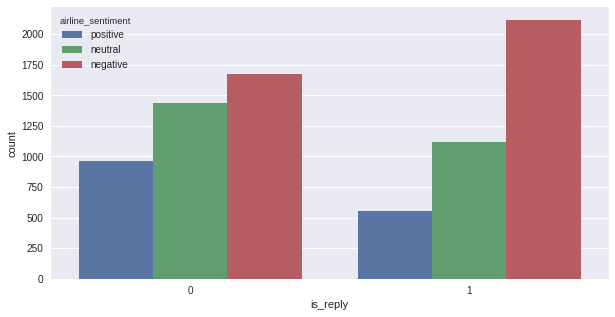

In [20]:
plt.figure(figsize = (10,5))
ax = sns.countplot(x = "is_reply",hue="airline_sentiment", data = df, orient = 'v')
plt.show()

### user_timezone

In [21]:
#Explore user_timezone
print(df.user_timezone.value_counts().head())

                              2748
Madrid                        1851
Pacific Time (US & Canada)     454
Buenos Aires                   327
Greenland                      245
Name: user_timezone, dtype: int64


###tweet_created

Now, we will try to get some extra information with tweet_created. We can create several new time features, such as:
1. Day of the year in which the tweet is created.
2. Day of the month in which the tweet is created.
3. Day of the week in which the tweet is created.

Also, a new column will be added corresponding to the **length of the text of the tweet** (it will be limited to 140, as we know a tweet can have a max of 140 chars).

Let's try to plot some boxplots depending on the airline sentiment, to see if these variables can be significant for our models:

In [22]:
df = create_num_features(df)
print(df.describe())

0         is_reply  day_of_month  day_of_week  day_of_year  text_length
count  7867.000000   7867.000000  7867.000000  7867.000000  7867.000000
mean      0.481886     17.115673     2.509089   305.324520   111.007500
std       0.499704      9.224388     1.779195    95.580863    33.076994
min       0.000000      1.000000     0.000000     1.000000    11.000000
25%       0.000000      8.000000     1.000000   317.000000    89.000000
50%       0.000000     18.000000     2.000000   332.000000   124.000000
75%       1.000000     25.000000     4.000000   349.000000   140.000000
max       1.000000     31.000000     6.000000   365.000000   158.000000


**Day of week**

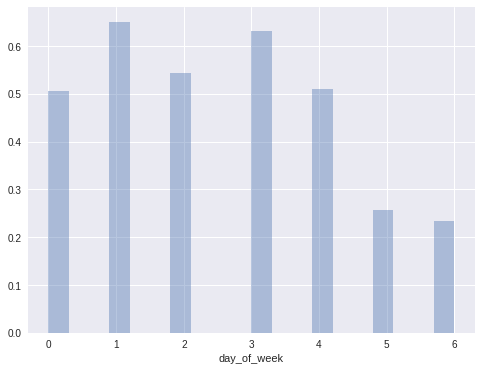

In [23]:
plt.figure(figsize= (8,6))
sns.distplot(df.day_of_week, kde = False, norm_hist = True)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


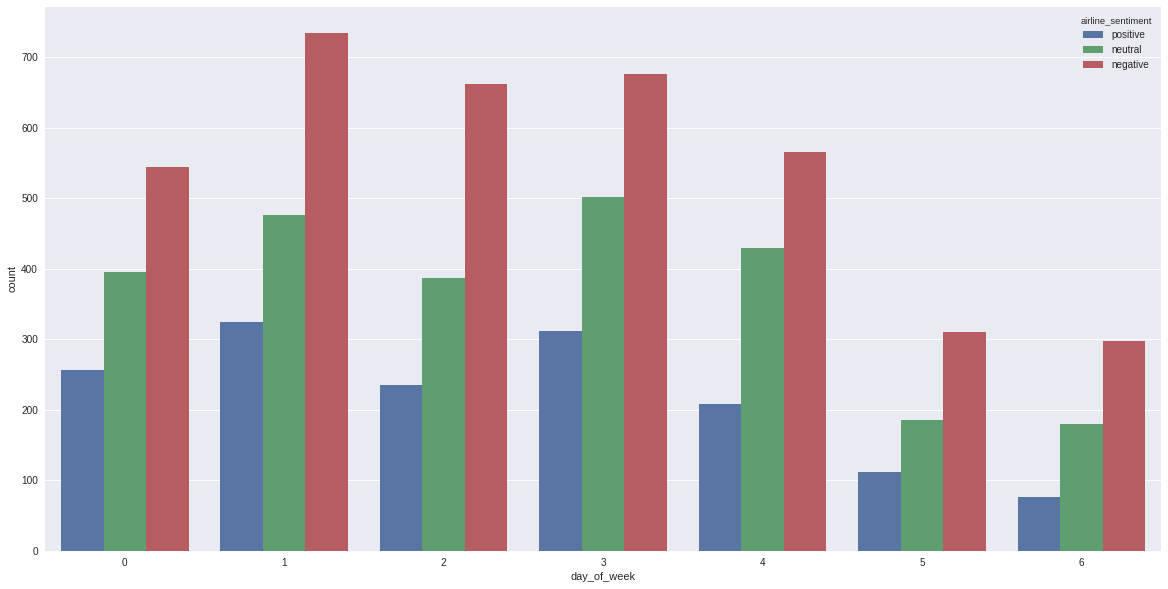

In [24]:
# Day of the week
plt.figure(figsize = (20,10))
ax = sns.countplot(x = "day_of_week", hue="airline_sentiment", data = df)
plt.show()

**Day of month**

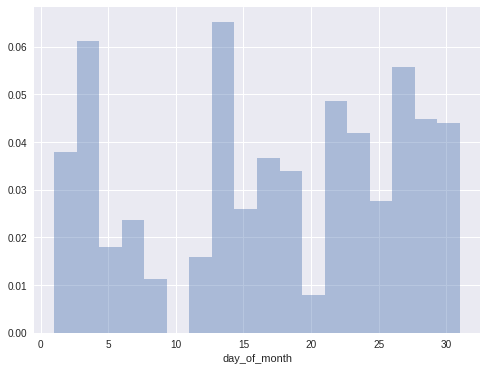

In [25]:
plt.figure(figsize= (8,6))
sns.distplot(df.day_of_month, kde = False, norm_hist = True)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


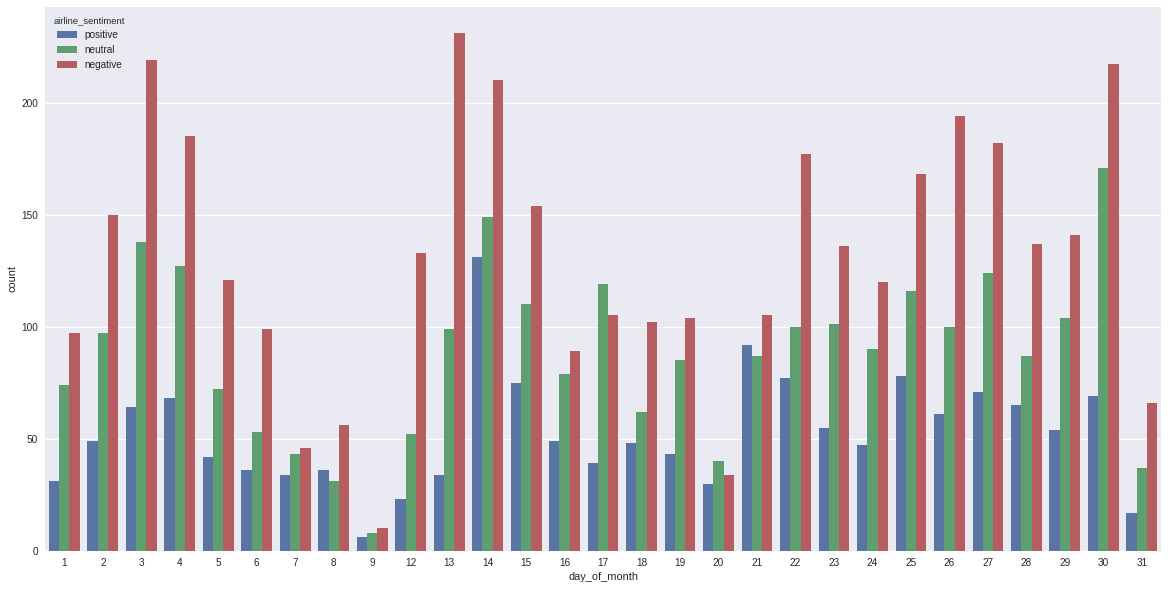

In [26]:
# Day of the month
plt.figure(figsize = (20,10))
ax = sns.countplot(x = "day_of_month",hue="airline_sentiment", data = df)
plt.show()

**Day of year**

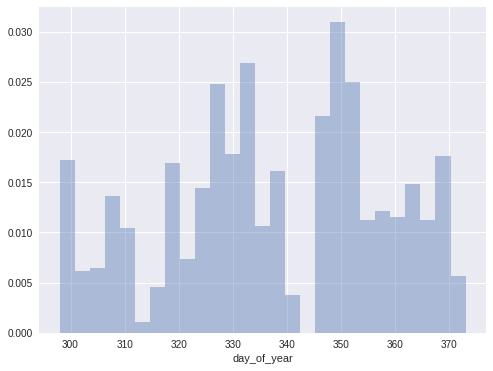

In [27]:
plt.figure(figsize= (8,6))
df['day_of_year'] = df.apply(lambda row: row.day_of_year if row.day_of_year > 100 else row.day_of_year + 365, axis = 1)
sns.distplot(df.day_of_year, kde = False, norm_hist = True)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


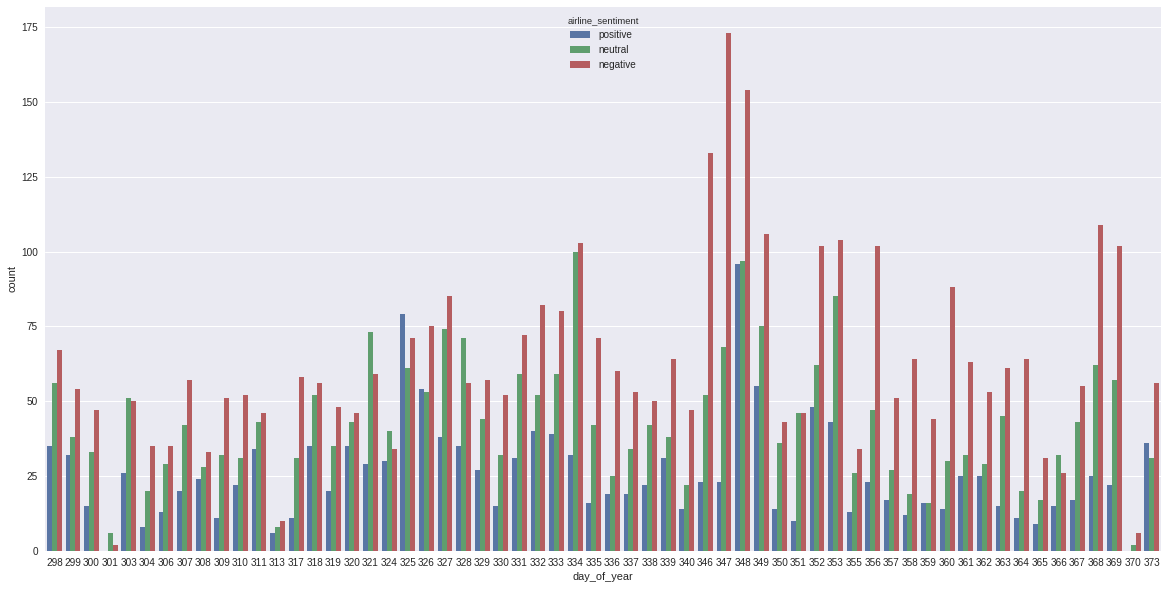

In [28]:
# Day of the year
plt.figure(figsize = (20,10))
ax = sns.countplot(x = "day_of_year",hue="airline_sentiment", data = df)
plt.show()

### length of the text of the tweet

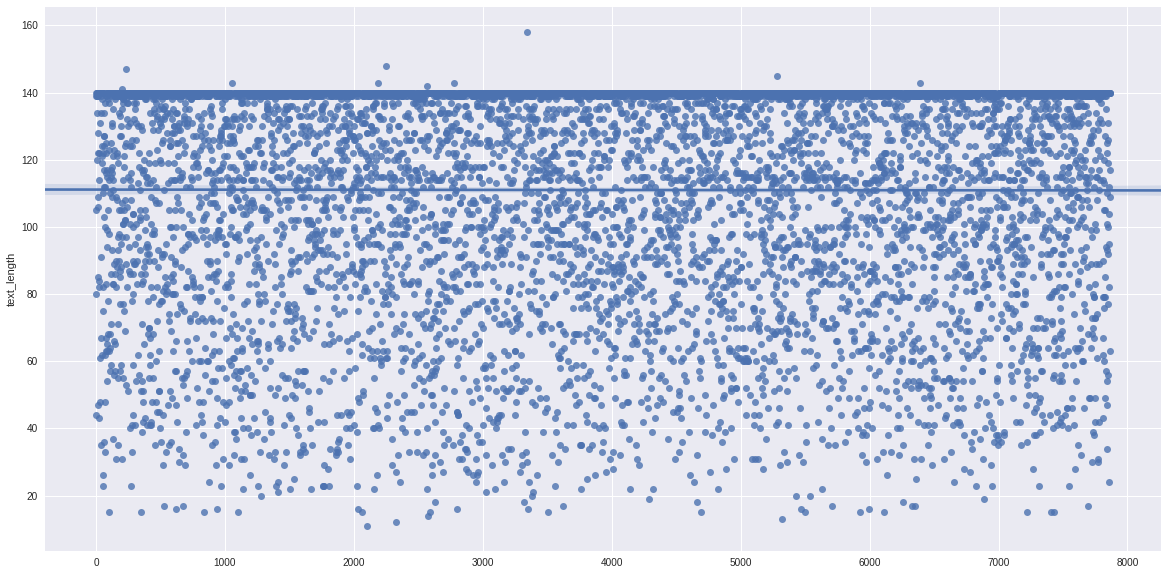

In [29]:
plt.figure(figsize = (20,10))
ax = sns.regplot(np.arange(len(df)), df.text_length)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


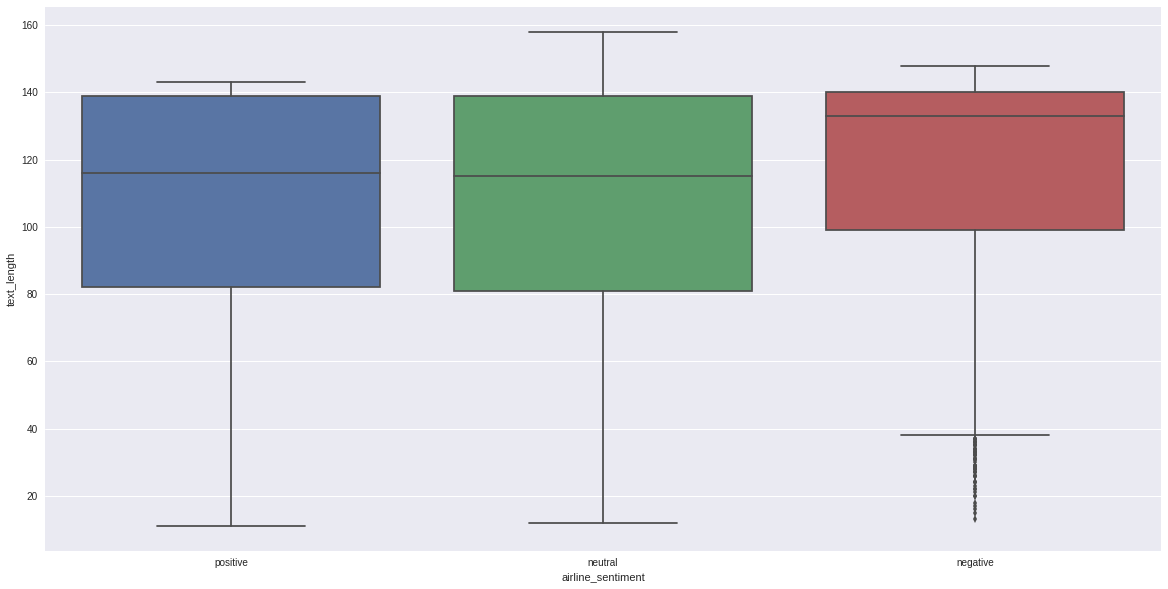

In [30]:
# Length of the tweet
plt.figure(figsize = (20,10))
ax = sns.boxplot(x = "airline_sentiment",y="text_length", data = df, orient = 'v')
plt.show()

The only ones that seem somewhat significant are the ***length of the text of the tweet*** and the ***'is_reply'*** attributes. For the moment, no numerical variables will be included as only two of them seem to be significant in some way.

## 6. Data Preparation

### 6.1 Drop Columns

In [31]:
#Drop reply_count, retweet_count, tweet_coord, tweet_id, tweet_location
df.drop(columns=['reply_count', 'retweet_count','tweet_coord', 'tweet_id','tweet_location'], axis = 1, inplace = True)

### 6.2 Clean Data

#### HTML decoding
It looks like HTML encoding has not been converted to text, and ended up in text field as ‘&lt’,’&gt’,etc. Decoding HTML to general text will be the first step of data preparation.

In [24]:
print(df.text[205])
htmldecoding(df)
print(df.text[205])

Curiosidades....  Madrid&lt;&gt;Barcelona en avión en 1927 = las 163 pesetas que costó el primer billete de Iberia... https://t.co/wtE2M1Jt3o
Curiosidades....  Madrid<>Barcelona en avión en 1927 = las 163 pesetas que costó el primer billete de Iberia... https://t.co/wtE2M1Jt3o


#### @ mentions
The second part of the preparation is dealing with @mention.
@mention can carry company information, therefore will extract this information.

In [31]:
print(df.text[2185])
#Adding a new column w/first mention found
addmention(df)
print(df.text_mention.describe())
print(df.text_mention.value_counts().head())

@Iberia Hola les escribo desde Mexico de una agencia de viajes necesito de su apoyo ya q el portal de Iberia < fact… https://t.co/uh8gytyOkh
count     7867
unique    1367
top       None
freq      2619
Name: text_mention, dtype: object
None        2619
@Iberia     2599
@Ryanair     314
@iberia      117
@vueling      46
Name: text_mention, dtype: int64


#### URL links
The third part of the cleaning is dealing with URL links. For sentiment analysis purpose URL links can be ignored. Will remove them.

In [30]:
print(df.text[2185])
df['text_clean'] = [remove_links(t) for t in df.text]
print(df.text_clean[2185])

@Iberia Hola les escribo desde Mexico de una agencia de viajes necesito de su apoyo ya q el portal de Iberia < fact… https://t.co/uh8gytyOkh
@Iberia Hola les escribo desde Mexico de una agencia de viajes necesito de su apoyo ya q el portal de Iberia < fact… 


## 7. Evaluate Algorithms

The **input (training) data** will now be pre-processed by using the function **obtain_data_representation** defined above. We will use the **TF-IDF** algorithm in order to transform the *text of the tweet* text column into a vector of numeric features. We will also try now a bit of **sentiment analysis**. We can get a lot of useful information about the sentiment of a tweet by analyzing the emojis that can be found in them. Hence, we will also include in the features the **emojis** that can be found in the text. Other features will be ignored for the moment, as we cannot observe a significant diffrerence between the different values of the objective variables for the numerical features selected. 

The columns of emojis and feature vector of text features extracted will be combined in order to generate a **sparse matrix**, containing as many rows as the number of records (tweets) provided, and a maximum of 250 + different emojis found columns.

This data will be stored under a dictionary. We actually have 2 dictionarys:
1. **dataset**: Contains the pre-process data without including the emoji part.
2. **dataset_em**: Contains the  pre-process data, including another numeric feature vector for the emojis found in the text.

### Obtain Data Representation

In [38]:
re_prep = re.compile(r'[^\u263a-\U0001f645]')

df['text'] = df.apply(lambda x: remove_links(x.text), axis = 1)
df['emojis'] = df.apply(lambda x: capture_emojis(x.text), axis = 1)

In [0]:
df.head()

,airline_sentiment,is_reply,text,tweet_created,user_timezone,emojis
1,positive,FALSE,"""Los pilotos de Ryanair desconvocan la huelga ...",Mon Dec 18 13:07:04 +0000 2017,Dublin,
2,positive,TRUE,"@Iberia @lavecinarubia Si ,por favor las decla...",Sat Nov 04 17:05:11 +0000 2017,,
3,neutral,TRUE,@Iberia Me dirías por favor que costo tiene?,Sat Dec 02 15:24:09 +0000 2017,,
4,negative,TRUE,"@SupermanlopezN @Iberia @giroditalia Champion,...",Thu Dec 21 23:17:43 +0000 2017,Central Time (US & Canada),
5,negative,TRUE,@SrtaFarrellDM @KLM @Iberia Eso de avianca es ...,Wed Dec 06 00:44:25 +0000 2017,Eastern Time (US & Canada),😤


In [39]:
dataset = obtain_data_representation(df, counter = 'TFIDF', stop_w = my_stop_words)
dataset_em = obtain_data_representation(df, counter = 'TFIDF', emojis = True, stop_w = my_stop_words)
dataset_bigrams = obtain_data_representation(df, counter = 'TFIDF', emojis = True, stop_w = my_stop_words,  bigrams = True)

BoW:  {'iberia': 114, 'tripulacion': 218, 'cambiar': 40, 'asiento': 19, 'aerolinea': 3, 'aerolineas': 4, 'avianca': 23, 'viaje': 230, 'buen': 34, 'ryanair': 195, 'menos': 138, 'dos': 73, 'horas': 110, 'oferta': 153, 'aniversario': 13, 'express': 92, 'mas': 136, 'van': 223, 'hora': 109, 'navidad': 145, 'gracias': 101, 'billetes': 31, 'cinco': 46, 'euros': 90, 'via': 228, 'retrasa': 192, 'enero': 78, 'cambio': 41, 'politica': 173, 'equipaje': 79, 'mano': 135, 'hacer': 104, 'check': 45, 'vuelo': 239, 'iberiaexpress': 115, 'buenos': 36, 'dias': 68, 'madrid': 129, 'diciembre': 70, 'airnostrumlam': 9, 'solo': 206, 'nuevos': 150, 'vuelos': 240, 'black': 32, 'friday': 98, 'pasajeros': 165, 'europa': 88, 'vueling': 238, 'hecho': 105, 'pasado': 163, 'minutos': 140, 'avion': 24, 'huelga': 112, 'personal': 168, 'tierra': 215, 'espana': 82, 'caso': 43, 'directo': 72, 'low': 126, 'cost': 55, 'problema': 178, 'web': 242, 'telefono': 212, 'cuenta': 57, 'ahora': 6, 'parte': 160, 'primer': 176, 'pais': 

In [40]:
print('The size of the training dataset is: (%i, %i)' % df.shape)
print ('---------------------------------------- ')

print ('Full pre-processed training data results size is: ' , dataset['train']['x'].shape)
print ('Full pre-processed training data with emojis size is: ', dataset_em['train']['x'].shape)
print ('Full pre-processed training data with bigrams size is: ', dataset_bigrams['train']['x'].shape)

print ('---------------------------------------- ')

print ('Full pre-processed testing data results size is: ', dataset['test']['x'].shape)
print ('Full pre-processed testing data with emojis size is: ', dataset_em['test']['x'].shape)
print ('Full pre-processed testing data with bigrams size is: ', dataset_bigrams['test']['x'].shape)

The size of the training dataset is: (7867, 11)
---------------------------------------- 
Full pre-processed training data results size is:  (5900, 243)
Full pre-processed training data with emojis size is:  (5900, 509)
Full pre-processed training data with bigrams size is:  (5900, 504)
---------------------------------------- 
Full pre-processed testing data results size is:  (1967, 243)
Full pre-processed testing data with emojis size is:  (1967, 509)
Full pre-processed testing data with bigrams size is:  (1967, 504)


In [41]:
print (dataset_bigrams['train']['x'])

  (0, 26)	0.8335897978837977
  (0, 103)	0.5184941665060434
  (0, 117)	0.1905041946080261
  (0, 244)	1.0
  (1, 15)	0.2557393297537015
  (1, 47)	0.31317104510693083
  (1, 56)	0.31317104510693083
  (1, 61)	0.3056222887010813
  (1, 78)	0.3122807637415658
  (1, 85)	0.3080282559845781
  (1, 97)	0.3122807637415658
  (1, 117)	0.08073225023619504
  (1, 139)	0.298270164487677
  (1, 156)	0.2837573555495544
  (1, 174)	0.28935913256539353
  (1, 191)	0.3088535509094803
  (1, 244)	1.0
  (2, 115)	0.6555630094576196
  (2, 173)	0.667984842825991
  (2, 199)	0.3521837452035585
  (2, 244)	1.0
  (3, 117)	0.2369915495864496
  (3, 226)	0.9715117114191746
  (3, 244)	1.0
  (4, 25)	0.27889613590682677
  :	:
  (5893, 208)	0.5319898035112746
  (5893, 244)	1.0
  (5894, 117)	1.0
  (5894, 244)	1.0
  (5895, 117)	1.0
  (5895, 244)	1.0
  (5896, 64)	0.5206473357627888
  (5896, 117)	0.128842333133049
  (5896, 184)	0.5301529775284256
  (5896, 188)	0.45901823441989015
  (5896, 204)	0.46964463783134336
  (5896, 244)	1.0
  (5

First, let's try a standard **Bernouilli NB** model:

In [42]:
clf = BernoulliNB()
clf.fit(dataset['train']['x'], dataset['train']['y'])
clf2 = BernoulliNB()
clf2.fit(dataset_em['train']['x'], dataset_em['train']['y'])
clf3 = BernoulliNB()
clf3.fit(dataset_bigrams['train']['x'], dataset_bigrams['train']['y'])


pred1 = clf.predict(dataset['test']['x'])
pred2 = clf2.predict(dataset_em['test']['x'])
pred3 = clf3.predict(dataset_bigrams['test']['x'])

print ('The score achieved by the model trained with the full training data is: %2.6f' % (accuracy_score(dataset['test']['y'], pred1)))
print ('The score achieved by the model trained with the training with emojis data is: %2.6f' % (accuracy_score(dataset_em['test']['y'], pred2)))
print ('The score achieved by the model trained with the training with bigrams data is: %2.6f' % (accuracy_score(dataset_bigrams['test']['y'], pred3)))

The score achieved by the model trained with the full training data is: 0.560752
The score achieved by the model trained with the training with emojis data is: 0.551601
The score achieved by the model trained with the training with bigrams data is: 0.548043


Confusion Matrix for the first Model 

[[0.58 0.29 0.13]
 [0.27 0.5  0.23]
 [0.18 0.34 0.48]]


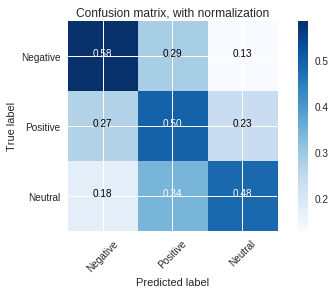

Confusion Matrix for the second model, with emojis

[[0.6  0.29 0.11]
 [0.28 0.51 0.22]
 [0.22 0.37 0.41]]


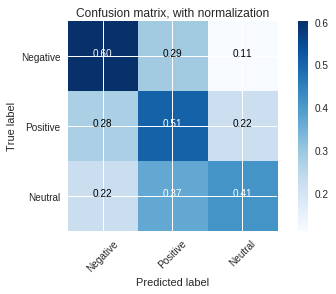

Confusion Matrix for the second model, with bigrams

[[0.59 0.27 0.13]
 [0.31 0.47 0.22]
 [0.24 0.3  0.46]]


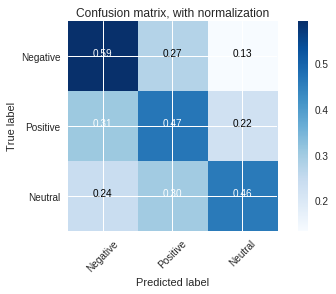

In [43]:
print ('Confusion Matrix for the first Model \n')
cnf_matrix1 = confusion_matrix(pred1, dataset['test']['y'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, with normalization')
plt.show()

print ('Confusion Matrix for the second model, with emojis\n')

cnf_matrix2 = confusion_matrix(pred2, dataset_em['test']['y'])
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, with normalization')
plt.show()

print ('Confusion Matrix for the second model, with bigrams\n')

cnf_matrix3 = confusion_matrix(pred3, dataset_bigrams['test']['y'])
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, with normalization')
plt.show()

### Model Selection
Now we'll try some different models in order to see which one provides better results.

In [45]:
#Results matrix definition 
results = pd.DataFrame({
    'Model' : ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier', 'Bernouilli Naive Bayes',
              'MultinomialNB', 'XGBoost'],
    })

In [46]:
gaussian = GaussianNB()
logreg = LogisticRegression()
svc = SVC()
linear_svc = LinearSVC()
perceptron = Perceptron()
decisiontree = DecisionTreeClassifier(criterion = 'entropy')
randomforest = RandomForestClassifier(criterion = 'entropy')
knn = KNeighborsClassifier()
sgd = SGDClassifier()
gbk = GradientBoostingClassifier()
bern = BernoulliNB()
multi = MultinomialNB()
xgboost = xgb.XGBClassifier()

In [0]:
#Testing models (20 iterations each)

p_l = 'negative'
for i in range(1,20):
    main_dataset = obtain_data_representation(df, emojis = True)
    
    x_train = main_dataset['train']['x'].toarray()
    y_train = main_dataset['train']['y']

    x_val = main_dataset['test']['x'].toarray()
    y_val = main_dataset['test']['y']
    '''if (i // 10 > 0):
        x_train, x_val, y_train, y_val = train_test_split(X, y_bin, test_size = 0.25)

    else:
        x_train, x_val, y_train, y_val = train_test_split(X, y_bin, test_size = 0.20)'''

    print('Calculating iteration ' + str(i))
    
    # Gaussian Naive Bayes:
    gaussian.fit(x_train, y_train)
    y_pred = gaussian.predict(x_val)
    acc_gau = accuracy_score(y_pred, y_val)
    '''f1_gau = f1_score(y_pred, y_val)
    rec_gau = recall_score(y_pred, y_val)
    prec_gau = precision_score(y_pred, y_val)'''
    
    # Logistic regression:
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_val)
    acc_lreg = accuracy_score(y_pred, y_val)
    '''f1_lreg = f1_score(y_pred, y_val)
    rec_lreg = recall_score(y_pred, y_val)
    prec_lreg = precision_score(y_pred, y_val)'''
    
    # SVMC y LSVMC:
    svc.fit(x_train, y_train)
    y_pred = svc.predict(x_val)
    acc_svmc = accuracy_score(y_pred, y_val)
    '''f1_svmc = f1_score(y_pred, y_val)
    rec_svmc = recall_score(y_pred, y_val)
    prec_svmc = precision_score(y_pred, y_val)'''
    
    linear_svc.fit(x_train, y_train)
    y_pred = linear_svc.predict(x_val)     
    acc_lsvmc = accuracy_score(y_pred, y_val)
    '''f1_lsvmc = f1_score(y_pred, y_val)
    rec_lsvmc = recall_score(y_pred, y_val)
    prec_lsvmc = precision_score(y_pred, y_val)'''
    
    # Perceptron:
    perceptron.fit(x_train, y_train)
    y_pred = perceptron.predict(x_val)
    acc_perceptron = accuracy_score(y_pred, y_val)
    '''f1_perceptron = f1_score(y_pred, y_val)
    rec_perceptron = recall_score(y_pred, y_val)
    prec_perceptron = precision_score(y_pred, y_val)'''
    
    # Decision tree:
    decisiontree.fit(x_train, y_train)
    y_pred = decisiontree.predict(x_val)
    acc_dtree = accuracy_score(y_pred, y_val)
    '''f1_dtree = f1_score(y_pred, y_val)
    rec_dtree = recall_score(y_pred, y_val)
    prec_dtree = precision_score(y_pred, y_val)'''
    
    # Random Forest:
    randomforest.fit(x_train, y_train)
    y_pred = randomforest.predict(x_val)
    acc_rf = accuracy_score(y_pred, y_val)
    '''f1_rf = f1_score(y_pred, y_val)
    rec_rf = recall_score(y_pred, y_val)
    prec_rf = precision_score(y_pred, y_val)'''
    
    # KNN:
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_val)
    acc_knn = accuracy_score(y_pred, y_val)
    '''f1_knn = f1_score(y_pred, y_val)
    rec_knn = recall_score(y_pred, y_val)
    prec_knn = precision_score(y_pred, y_val)'''
    
    # Gradient Descent:
    sgd.fit(x_train, y_train)
    y_pred = sgd.predict(x_val)    
    acc_sgd = accuracy_score(y_pred, y_val)
    '''f1_sgd = f1_score(y_pred, y_val)
    rec_sgd = recall_score(y_pred, y_val)
    prec_sgd = precision_score(y_pred, y_val)'''
    
    # Gradient boosting:
    gbk.fit(x_train, y_train)
    y_pred = gbk.predict(x_val)
    acc_gbk = accuracy_score(y_pred, y_val)
    '''f1_gbk = f1_score(y_pred, y_val)
    rec_gbk = recall_score(y_pred, y_val)
    prec_gbk = precision_score(y_pred, y_val)'''
    
    # Bernouilli Naive Bayes:
    bern.fit(x_train, y_train)
    y_pred = bern.predict(x_val)
    acc_bern = accuracy_score(y_pred, y_val)
    '''f1_ber = f1_score(y_pred, y_val)
    rec_ber = recall_score(y_pred, y_val)
    prec_ber = precision_score(y_pred, y_val)'''
    
    # Multinomial Naive Bayes:
    multi.fit(x_train, y_train)
    y_pred = multi.predict(x_val)
    acc_multi = accuracy_score(y_pred, y_val)
    '''f1_mul = f1_score(y_pred, y_val)
    rec_mul = recall_score(y_pred, y_val)
    prec_mul = precision_score(y_pred, y_val)'''
    
    # xgboost:
    xgboost.fit(x_train, y_train)
    y_pred = xgboost.predict(x_val)
    acc_xgb = accuracy_score(y_pred, y_val)
    '''f1_xgb = f1_score(y_pred, y_val)
    rec_xgb = recall_score(y_pred, y_val)
    prec_xgb = precision_score(y_pred, y_val)'''
    
    
    results['Accuracy_'+str(i)] = [acc_svmc, acc_knn, acc_lreg, 
              acc_rf, acc_gau, acc_perceptron,acc_lsvmc, acc_dtree,
              acc_sgd, acc_gbk, acc_bern, acc_multi, acc_xgb]
    '''results['F1_score_'+str(i)] = [f1_svmc, f1_knn, f1_lreg, 
              f1_rf, f1_gau, f1_perceptron,f1_lsvmc, f1_dtree,
              f1_sgd, f1_gbk, f1_ber, f1_mul, f1_xgb]
    results['Recall_'+str(i)] = [rec_svmc, rec_knn, rec_lreg, 
              rec_rf, rec_gau, rec_perceptron,rec_lsvmc, rec_dtree,
              rec_sgd, rec_gbk, rec_ber, rec_mul, rec_xgb]
    results['Precision_'+str(i)] = [prec_svmc, prec_knn, prec_lreg, 
              prec_rf, prec_gau, prec_perceptron,prec_lsvmc, prec_dtree,
              prec_sgd, prec_gbk, prec_ber, prec_mul, prec_xgb]'''
    
    

BoW:  {'asi': 21, 'fue': 122, 'accidente': 1, 'del': 72, 'vuelo': 298, 'spanair': 259, 'mas': 169, 'letal': 152, 'espana': 100, 'decadas': 69, 'video': 293, 'ryanair': 242, 'primera': 223, 'huelga': 139, 'pilotos': 213, 'iberia': 140, 'con': 60, 'billetes': 36, 'por': 218, 'menos': 171, 'euros': 114, 'entre': 93, 'madrid': 161, 'no': 185, 'hola': 133, 'esta': 106, 'estoy': 111, 'intentando': 146, 'check': 51, 'desde': 74, 'ayer': 30, 'reserva': 238, 'poco': 215, 'puedo': 229, 'tan': 263, 'hace': 127, 'hora': 136, 'como': 56, 'ver': 286, 'via': 289, 'barcelona': 33, 'las': 150, 'dan': 68, 'otro': 197, 'cliente': 54, 'son': 258, 'que': 232, 'asientos': 23, 'muchos': 179, 'vuelos': 299, 'black': 37, 'friday': 121, 'les': 151, 'nadie': 182, 'despues': 76, 'los': 157, 'tienen': 270, 'asiento': 22, 'lanza': 149, 'low': 158, 'cost': 64, 'para': 202, 'aerolinea': 4, 'veces': 285, 'tengo': 267, 'hacer': 128, 'una': 278, 'viaje': 291, 'igual': 143, 'espero': 105, 'ese': 97, 'cosas': 63, 'viajes'

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'ryanair': 236, 'no': 182, 'tengo': 261, 'respuesta': 232, 'por': 212, 'parte': 197, 'como': 52, 'con': 56, 'iberia': 141, 'destino': 75, 'solo': 250, 'click': 49, 'deseadme': 73, 'suerte': 254, 'holaargentina': 134, 'hola': 133, 'destinos': 76, 'europeos': 112, 'mejor': 169, 'precio': 214, 'los': 156, 'vuelos': 295, 'mad': 159, 'les': 151, 'las': 150, 'que': 225, 'para': 195, 'madrid': 160, 'aerolinea': 4, 'acabo': 0, 'volar': 290, 'sevilla': 244, 'avion': 26, 'muy': 177, 'cambio': 44, 'check': 48, 'pues': 224, 'dicen': 79, 'avios': 28, 'british': 36, 'voy': 292, 'viaje': 285, 'gracias': 125, 'mas': 168, 'espanoles': 100, 'viajes': 286, 'hay': 131, 'problema': 218, 'entre': 91, 'cosas': 58, 'han': 129, 'easyjet': 85, 'iberiaexpress': 142, 'pasa': 198, 'tripulantes': 272, 'cabina': 41, 'low': 157, 'cost': 59, 'una': 273, 'compania': 53, 'anos': 17, 'intentando': 146, 'vuelo': 294, 'vuelta': 296, 'nos': 183, 'favor': 117, 'pasajeros': 201, 'demora': 71, 'del': 70, 'dinero': 81, '

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'iberia': 137, 'samsungespana': 239, 'del': 67, 'todo': 265, 'ryanair': 236, 'vueling': 288, 'las': 145, 'companias': 52, 'con': 54, 'mas': 162, 'vuelos': 290, 'los': 151, 'que': 226, 'por': 211, 'navidad': 176, 'holacolombia': 131, 'enero': 86, 'voy': 287, 'nuevo': 184, 'no': 179, 'este': 103, 'pais': 194, 'ver': 277, 'puedo': 223, 'tambien': 255, 'diciembre': 77, 'ruta': 235, 'londres': 150, 'sin': 246, 'pueden': 222, 'para': 195, 'vuelo': 289, 'estoy': 105, 'tengo': 260, 'destino': 72, 'solo': 249, 'click': 48, 'deseadme': 70, 'suerte': 253, 'hola': 129, 'destinos': 73, 'europeos': 107, 'mejor': 163, 'precio': 213, 'aerolinea': 3, 'nos': 180, 'maleta': 157, 'cuando': 60, 'ahora': 6, 'todos': 266, 'estan': 101, 'sus': 254, 'maletas': 158, 'una': 270, 'experiencia': 110, 'son': 250, 'sigue': 245, 'esta': 100, 'esperando': 97, 'espana': 95, 'desde': 69, 'hace': 123, 'dias': 75, 'pero': 204, 'parece': 196, 'hacer': 124, 'eso': 93, 'viaje': 282, 'otra': 190, 'madrid': 154, 'semana

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'ryanair': 239, 'tripulantes': 272, 'sevilla': 246, 'via': 285, 'ayer': 29, 'ese': 98, 'iberia': 142, 'hace': 128, 'compania': 56, 'tambien': 257, 'sindicatos': 250, 'vuelo': 294, 'para': 198, 'hola': 134, 'como': 55, 'puedo': 225, 'una': 273, 'reclamacion': 232, 'iberiaexpress': 143, 'muchas': 174, 'gracias': 126, 'aeropuerto': 5, 'sin': 249, 'despues': 77, 'nos': 183, 'cuando': 66, 'hacer': 129, 'embarque': 91, 'hora': 137, 'llevo': 154, 'mucho': 175, 'tiempo': 263, 'con': 60, 'vosotros': 291, 'servicio': 245, 'atencion': 23, 'cliente': 53, 'parte': 200, 'equipaje': 94, 'mal': 160, 'reconocera': 233, 'los': 156, 'del': 74, 'personal': 208, 'cabina': 42, 'hoy': 139, 'que': 228, 'avion': 26, 'problemas': 222, 'vueling': 293, 'controladores': 62, 'alguien': 13, 'manana': 164, 'primera': 220, 'pilotos': 209, 'pago': 196, 'todos': 268, 'estoy': 112, 'las': 150, 'destino': 78, 'solo': 252, 'click': 52, 'deseadme': 76, 'suerte': 255, 'holaargentina': 135, 'destinos': 79, 'europeos': 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'como': 52, 'alguien': 12, 'que': 229, 'mas': 167, 'puede': 224, 'asiento': 21, 'iberia': 137, 'mis': 172, 'estan': 102, 'poder': 212, 'una': 276, 'compania': 53, 'tan': 261, 'buenos': 39, 'nos': 185, 'espero': 99, 'vuelo': 297, 'madrid': 159, 'destino': 73, 'por': 214, 'retraso': 238, 'londres': 154, 'avianca': 25, 'no': 184, 'con': 57, 'ryanair': 240, 'pueden': 225, 'viajar': 289, 'otro': 194, 'porque': 215, 'los': 155, 'son': 256, 'unos': 278, 'tengo': 265, 'donde': 81, 'gracias': 121, 'billetes': 33, 'desde': 70, 'euros': 109, 'del': 68, 'tripulantes': 275, 'air': 7, 'europa': 107, 'sus': 259, 'vuelos': 298, 'ano': 15, 'era': 90, 'cuando': 62, 'las': 147, 'ver': 284, 'maleta': 162, 'reserva': 235, 'esta': 100, 'pero': 208, 'mejor': 168, 'pasado': 204, 'todo': 270, 'fue': 118, 'tiempo': 266, 'busca': 40, 'viajes': 291, 'verguenza': 286, 'servicio': 246, 'atencion': 23, 'nunca': 190, 'peor': 207, 'ademas': 1, 'solo': 255, 'tiene': 267, 'ida': 139, 'pago': 197, 'para': 199, 'we

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'iberia': 142, 'peor': 208, 'gracias': 125, 'bueno': 38, 'que': 230, 'dias': 79, 'huelga': 140, 'aena': 2, 'mis': 174, 'hoy': 139, 'con': 58, 'destino': 76, 'solo': 255, 'click': 50, 'deseadme': 74, 'suerte': 259, 'holacolombia': 136, 'hola': 134, 'destinos': 77, 'europeos': 113, 'mejor': 170, 'precio': 219, 'muy': 180, 'bien': 32, 'asiento': 20, 'volar': 293, 'para': 200, 'sobre': 254, 'grupo': 126, 'viajar': 289, 'muchas': 176, 'del': 71, 'telefono': 264, 'como': 53, 'pilotos': 211, 'ryanair': 240, 'diciembre': 81, 'no': 185, 'hay': 132, 'los': 157, 'embarque': 89, 'barcelona': 31, 'mundo': 179, 'hecho': 133, 'las': 150, 'maletas': 165, 'pero': 209, 'antes': 17, 'sindicatos': 253, 'tierra': 270, 'espana': 99, 'madrid': 161, 'compra': 56, 'air': 7, 'via': 288, 'avianca': 25, 'luego': 159, 'aun': 23, 'maleta': 164, 'asi': 19, 'fue': 122, 'accidente': 0, 'vuelo': 297, 'spanair': 258, 'mas': 169, 'letal': 152, 'decadas': 68, 'video': 292, 'siempre': 250, 'hacer': 129, 'una': 278, 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'iberia': 143, 'asi': 22, 'avion': 28, 'por': 221, 'primera': 226, 'vez': 290, 'inaugura': 147, 'nuevo': 192, 'espacio': 99, 'premium': 224, 'para': 204, 'como': 53, 'una': 279, 'hoy': 140, 'las': 153, 'madrid': 164, 'no': 188, 'puedo': 232, 'hacer': 130, 'check': 49, 'que': 235, 'holacolombia': 137, 'ese': 97, 'pais': 203, 'gente': 124, 'con': 58, 'ryanair': 245, 'pero': 213, 'iberiaexpress': 144, 'sus': 263, 'vuelos': 302, 'despues': 75, 'anos': 18, 'los': 160, 'pilotos': 215, 'sindicatos': 257, 'todos': 275, 'compania': 54, 'son': 260, 'pasajeros': 210, 'parece': 205, 'esto': 109, 'maleta': 167, 'hace': 129, 'dias': 80, 'donde': 85, 'esta': 105, 'tengo': 269, 'estoy': 110, 'destino': 76, 'solo': 259, 'click': 50, 'deseadme': 74, 'suerte': 262, 'hola': 135, 'destinos': 77, 'europeos': 112, 'mejor': 173, 'precio': 223, 'cuando': 64, 'del': 71, 'spanair': 261, 'espana': 100, 'gracias': 125, 'nos': 189, 'respuesta': 242, 'quiero': 238, 'comprar': 57, 'asiento': 23, 'deja': 70, 'h

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'ryanair': 242, 'madrid': 163, 'travelthursday': 275, 'asi': 22, 'fue': 126, 'accidente': 1, 'del': 74, 'vuelo': 298, 'spanair': 259, 'mas': 171, 'letal': 155, 'espana': 104, 'decadas': 72, 'video': 293, 'con': 61, 'estan': 110, 'cabina': 44, 'sin': 253, 'que': 231, 'iberia': 145, 'maleta': 166, 'hace': 132, 'dias': 83, 'mis': 176, 'no': 186, 'compania': 57, 'primer': 222, 'destino': 79, 'barcelona': 34, 'muchas': 178, 'gracias': 129, 'feliz': 124, 'ano': 17, 'las': 153, 'iberiaexpress': 146, 'airnostrumlam': 11, 'aireuropa': 10, 'por': 218, 'viajar': 289, 'desde': 76, 'euros': 117, 'entre': 96, 'los': 159, 'meses': 174, 'holacolombia': 140, 'quiero': 234, 'diciembre': 85, 'todos': 273, 'esta': 109, 'vez': 287, 'nueva': 189, 'solo': 256, 'click': 53, 'deseadme': 77, 'suerte': 260, 'hola': 138, 'destinos': 80, 'europeos': 116, 'mejor': 172, 'precio': 220, 'argentina': 21, 'tripulacion': 276, 'sigue': 252, 'una': 277, 'reconocera': 236, 'sindicatos': 254, 'cambio': 47, 'para': 201

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'igual': 142, 'este': 105, 'del': 70, 'iberia': 139, 'ryanair': 236, 'sus': 254, 'esta': 103, 'una': 271, 'que': 226, 'verguenza': 281, 'no': 182, 'vuelo': 293, 'ida': 141, 'vuelta': 295, 'madrid': 159, 'por': 212, 'retraso': 234, 'otro': 193, 'avion': 27, 'poder': 210, 'quien': 228, 'decir': 68, 'volando': 288, 'con': 58, 'esto': 106, 'viajar': 284, 'mejor': 168, 'uno': 272, 'los': 155, 'nuevos': 187, 'aviones': 28, 'solo': 249, 'tambien': 255, 'han': 127, 'aun': 25, 'asi': 21, 'vuelos': 294, 'bien': 34, 'espana': 98, 'precio': 214, 'esa': 94, 'mal': 160, 'funciona': 120, 'atencion': 24, 'cliente': 52, 'mas': 167, 'sobre': 248, 'problemas': 219, 'pero': 205, 'siempre': 244, 'casi': 47, 'para': 197, 'horas': 135, 'informacion': 143, 'eso': 96, 'pagar': 194, 'otra': 192, 'vez': 282, 'pais': 196, 'hay': 129, 'embarque': 87, 'barcelona': 33, 'mundo': 176, 'ahora': 7, 'nos': 183, 'reconocera': 231, 'sindicatos': 247, 'personal': 206, 'cabina': 43, 'via': 283, 'respuesta': 233, 'prob

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'ryanair': 240, 'avion': 27, 'por': 216, 'como': 54, 'iberia': 141, 'no': 183, 'funciona': 124, 'dias': 80, 'del': 71, 'que': 229, 'ustedes': 278, 'han': 130, 'mismo': 174, 'billete': 34, 'nuevo': 187, 'porque': 217, 'madrid': 160, 'travelthursday': 272, 'con': 59, 'destino': 76, 'solo': 254, 'click': 51, 'deseadme': 74, 'suerte': 257, 'holacolombia': 136, 'hola': 134, 'destinos': 77, 'europeos': 113, 'mejor': 169, 'precio': 218, 'tiene': 266, 'luego': 158, 'parece': 200, 'compania': 55, 'pero': 208, 'numero': 189, 'pasajeros': 205, 'cambiar': 44, 'asiento': 22, 'antes': 18, 'vuelo': 297, 'hacer': 129, 'check': 50, 'sus': 258, 'despues': 75, 'primer': 220, 'esta': 106, 'billetes': 35, 'todo': 269, 'mundo': 177, 'cancelacion': 46, 'mas': 168, 'vuelos': 298, 'aqui': 19, 'express': 116, 'fue': 123, 'las': 149, 'favor': 118, 'les': 150, 'demora': 72, 'devolucion': 78, 'dinero': 83, 'todos': 270, 'los': 156, 'viajes': 290, 'londres': 155, 'son': 255, 'asi': 21, 'primera': 221, 'bien'

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'con': 57, 'iberia': 138, 'destino': 74, 'solo': 248, 'click': 50, 'deseadme': 72, 'suerte': 251, 'holacolombia': 133, 'hola': 131, 'destinos': 75, 'europeos': 110, 'mejor': 164, 'precio': 214, 'nuevo': 183, 'vuelos': 289, 'viajar': 280, 'hace': 125, 'como': 52, 'feliz': 118, 'este': 106, 'mucho': 171, 'mas': 163, 'siempre': 243, 'igual': 141, 'ryanair': 235, 'los': 151, 'aviones': 29, 'nueva': 182, 'ruta': 234, 'aeropuerto': 6, 'tras': 265, 'anos': 18, 'gracias': 123, 'una': 268, 'sus': 252, 'pasajeros': 201, 'que': 225, 'por': 212, 'vuestra': 291, 'web': 292, 'para': 194, 'error': 94, 'veces': 274, 'plus': 207, 'cumple': 65, 'queremos': 226, 'celebrarlo': 48, 'contigo': 58, 'manera': 161, 'muy': 173, 'especial': 99, 'elige': 86, 'numero': 185, 'favorito': 116, 'menos': 165, 'dos': 84, 'horas': 135, 'oferta': 187, 'aniversario': 16, 'express': 113, 'embarque': 88, 'del': 69, 'vuelo': 288, 'samsungespana': 238, 'todos': 264, 'via': 279, 'mis': 168, 'mal': 156, 'no': 178, 'caso':

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'directo': 84, 'vuelo': 300, 'con': 59, 'iberia': 142, 'dias': 80, 'desde': 74, 'nuevo': 190, 'espacio': 98, 'premium': 222, 'para': 203, 'como': 54, 'una': 279, 'destino': 77, 'solo': 257, 'click': 52, 'deseadme': 75, 'suerte': 261, 'holacolombia': 136, 'hola': 134, 'destinos': 78, 'europeos': 112, 'mejor': 171, 'precio': 221, 'express': 116, 'italia': 149, 'quien': 235, 'cancelacion': 46, 'del': 72, 'no': 185, 'madrid': 162, 'muchas': 177, 'gracias': 126, 'por': 219, 'las': 151, 'dan': 68, 'siempre': 252, 'tambien': 263, 'ademas': 2, 'necesito': 184, 'facturar': 117, 'dos': 86, 'cada': 43, 'tiene': 270, 'esperando': 101, 'maleta': 165, 'barcelona': 33, 'nadie': 182, 'puede': 228, 'nos': 186, 'iberiaexpress': 143, 'viaje': 293, 'espana': 99, 'que': 233, 'fue': 123, 'vueling': 299, 'tengo': 268, 'ida': 144, 'vuelta': 302, 'dicen': 81, 'les': 152, 'espero': 103, 'compra': 57, 'estaba': 105, 'viajar': 292, 'ryanair': 244, 'cosas': 61, 'hasta': 131, 'los': 158, 'esperar': 102, 'per

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'con': 57, 'iberia': 136, 'destino': 74, 'solo': 248, 'click': 50, 'deseadme': 72, 'suerte': 252, 'holacolombia': 131, 'hola': 129, 'destinos': 75, 'europeos': 110, 'mejor': 164, 'precio': 213, 'pero': 204, 'no': 179, 'deja': 68, 'ser': 240, 'que': 223, 'los': 151, 'mas': 163, 'pues': 222, 'servicio': 241, 'uno': 271, 'pueden': 220, 'van': 275, 'nunca': 186, 'por': 211, 'favor': 113, 'pasajeros': 201, 'les': 146, 'demora': 70, 'del': 69, 'dinero': 80, 'para': 195, 'nada': 175, 'pasajero': 200, 'vuelo': 290, 'aniversario': 14, 'casi': 46, 'volando': 285, 'nos': 180, 'sin': 245, 'maletas': 159, 'todo': 264, 'viaje': 282, 'esta': 102, 'ryanair': 233, 'meses': 166, 'esperando': 99, 'una': 270, 'retraso': 231, 'horas': 133, 'estas': 105, 'express': 112, 'oferta': 187, 'lanza': 144, 'ofertas': 188, 'volar': 286, 'como': 52, 'donde': 82, 'las': 145, 'gente': 120, 'luego': 153, 'desde': 71, 'sevilla': 242, 'avion': 25, 'asi': 19, 'feliz': 116, 'tiene': 261, 'han': 125, 'tambien': 254, '

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'aqui': 21, 'ryanair': 246, 'esperando': 109, 'alguien': 15, 'ruta': 245, 'aerolineas': 5, 'barcelona': 35, 'aerolinea': 4, 'low': 164, 'cost': 67, 'iberia': 150, 'hola': 142, 'vuelo': 301, 'esta': 112, 'estoy': 118, 'check': 53, 'desde': 80, 'ayer': 32, 'reserva': 241, 'como': 57, 'para': 205, 'una': 281, 'tripulacion': 279, 'que': 235, 'hace': 136, 'unos': 283, 'dias': 86, 'gracias': 133, 'vueling': 300, 'pagina': 202, 'web': 305, 'compre': 62, 'con': 63, 'asi': 23, 'hacer': 137, 'mis': 179, 'maletas': 170, 'tiempo': 270, 'dinero': 89, 'habeis': 135, 'sin': 256, 'nada': 185, 'nos': 191, 'han': 138, 'los': 163, 'vuelos': 302, 'no': 190, 'donde': 91, 'cuando': 70, 'las': 157, 'linea': 160, 'llevo': 161, 'dos': 92, 'horas': 146, 'cada': 47, 'por': 221, 'telefono': 267, 'cambiar': 48, 'vuestra': 304, 'del': 78, 'favor': 126, 'numero': 195, 'demora': 79, 'equipaje': 100, 'buenas': 42, 'problemas': 228, 'error': 102, 'mas': 174, 'porque': 222, 'les': 158, 'viaje': 294, 'anos': 19, '

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'enero': 91, 'ryanair': 239, 'madrid': 159, 'british': 38, 'airways': 12, 'iberia': 140, 'por': 213, 'favor': 117, 'pasajeros': 203, 'que': 228, 'les': 150, 'nuevo': 187, 'espacio': 99, 'premium': 217, 'aeropuerto': 6, 'air': 8, 'viaje': 287, 'semana': 245, 'para': 198, 'plus': 208, 'manana': 164, 'maleta': 162, 'asi': 22, 'fue': 122, 'accidente': 1, 'del': 71, 'vuelo': 294, 'spanair': 257, 'mas': 167, 'letal': 151, 'espana': 100, 'decadas': 68, 'video': 289, 'hoy': 138, 'barcelona': 33, 'con': 58, 'vuelos': 295, 'como': 54, 'creo': 63, 'uno': 276, 'sus': 259, 'aviones': 29, 'puedo': 225, 'informacion': 144, 'espero': 104, 'una': 275, 'hora': 136, 'mis': 172, 'maletas': 163, 'esa': 96, 'vuestra': 297, 'compania': 55, 'aqui': 20, 'tambien': 260, 'no': 183, 'hace': 127, 'anos': 18, 'ese': 97, 'billete': 35, 'via': 285, 'esta': 105, 'black': 37, 'friday': 121, 'desde': 73, 'donde': 84, 'vueling': 293, 'pagina': 196, 'web': 298, 'siempre': 249, 'las': 149, 'precios': 216, 'gracias':

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'desde': 73, 'por': 213, 'euros': 112, 'ida': 141, 'mas': 166, 'que': 226, 'con': 58, 'ryanair': 236, 'iberia': 139, 'favor': 115, 'para': 197, 'una': 274, 'vueling': 295, 'vuelo': 296, 'los': 154, 'maleta': 161, 'dia': 78, 'mis': 171, 'sin': 247, 'respuesta': 233, 'air': 6, 'gracias': 123, 'las': 148, 'esta': 104, 'linea': 151, 'no': 182, 'llevo': 152, 'nada': 177, 'saber': 237, 'reclamacion': 230, 'habeis': 124, 'tengo': 262, 'otra': 191, 'dos': 85, 'maletas': 162, 'cuanto': 65, 'pagar': 193, 'quiero': 229, 'horas': 135, 'retraso': 234, 'airnostrumlam': 9, 'aerolineas': 3, 'son': 252, 'pero': 206, 'avianca': 25, 'ahora': 5, 'les': 149, 'del': 71, 'diciembre': 81, 'empresa': 89, 'cosas': 61, 'muy': 176, 'bien': 32, 'pues': 225, 'telefono': 260, 'primera': 218, 'huelga': 137, 'pilotos': 208, 'hasta': 128, 'eso': 97, 'mismo': 172, 'hace': 125, 'semana': 241, 'volar': 292, 'servicio': 243, 'atencion': 23, 'cliente': 51, 'creo': 63, 'nueva': 185, 'madrid': 158, 'este': 107, 'menos'

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/prepr

BoW:  {'iberia': 145, 'una': 281, 'los': 162, 'cosas': 62, 'del': 73, 'viaje': 294, 'ryanair': 243, 'nos': 191, 'que': 234, 'hacen': 131, 'dos': 87, 'vuelo': 302, 'pilotos': 216, 'irlanda': 151, 'italia': 152, 'van': 286, 'huelga': 143, 'antes': 19, 'navidad': 187, 'via': 292, 'porque': 222, 'creo': 64, 'por': 221, 'pasajeros': 212, 'gracias': 128, 'oferta': 199, 'vueling': 301, 'easyjet': 88, 'politica': 220, 'reconocera': 238, 'sindicatos': 256, 'buenas': 40, 'este': 110, 'con': 59, 'ano': 17, 'equipaje': 94, 'cabina': 43, 'hoy': 142, 'puedo': 231, 'decir': 71, 'aeropuerto': 6, 'todos': 275, 'solo': 258, 'favor': 120, 'eso': 99, 'tambien': 264, 'pero': 214, 'parte': 208, 'tener': 268, 'no': 190, 'quiero': 236, 'servicio': 251, 'clientes': 53, 'uno': 282, 'reserva': 239, 'despues': 77, 'tiempo': 270, 'avion': 28, 'airnostrumlam': 11, 'maletas': 170, 'llego': 158, 'otra': 201, 'tras': 276, 'dias': 81, 'esta': 106, 'billetes': 36, 'todo': 274, 'mundo': 183, 'mas': 174, 'vuelos': 303, 'p

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [49]:
results.index = results.Model
accuracy = results[['Accuracy_' + str(i) for i in range(1,20)]]
accuracy.index = results.Model
accuracy['mean_accuracy'] = accuracy.mean(axis = 1)
accuracy

,Accuracy_1,Accuracy_2,Accuracy_3,Accuracy_4,Accuracy_5,Accuracy_6,Accuracy_7,Accuracy_8,Accuracy_9,Accuracy_10,Accuracy_11,Accuracy_12,Accuracy_13,Accuracy_14,Accuracy_15,Accuracy_16,Accuracy_17,Accuracy_18,Accuracy_19,mean_accuracy
Model,,,,,,,,,,,,,,,,,,,,
Support Vector Machines,0.484494,0.477377,0.477885,0.491612,0.493137,0.477377,0.498729,0.479919,0.469243,0.478902,0.486528,0.490086,0.460600,0.483986,0.487036,0.478393,0.483986,0.479919,0.484494,0.482300
KNN,0.453991,0.474835,0.521098,0.500763,0.536350,0.502288,0.462125,0.490086,0.484494,0.498221,0.504830,0.509405,0.480427,0.517539,0.506863,0.477885,0.534316,0.464159,0.458058,0.493565
Logistic Regression,0.577021,0.549568,0.555160,0.554652,0.564311,0.565836,0.561261,0.572954,0.555669,0.554143,0.547026,0.553635,0.540925,0.567870,0.550076,0.568887,0.556177,0.547026,0.566853,0.558371
Random Forest,0.512964,0.512964,0.512456,0.532791,0.509405,0.480935,0.483986,0.517031,0.521607,0.530757,0.539400,0.518048,0.499746,0.532283,0.552618,0.533808,0.537367,0.538383,0.544484,0.521633
Naive Bayes,0.559736,0.528724,0.539908,0.543467,0.555160,0.546518,0.557194,0.533299,0.520081,0.528216,0.486528,0.549568,0.514489,0.534316,0.510930,0.550585,0.543467,0.536858,0.553635,0.536457
Perceptron,0.492628,0.315709,0.358414,0.421454,0.267412,0.491103,0.523640,0.478902,0.507880,0.516523,0.498221,0.481444,0.512964,0.506863,0.556177,0.537875,0.516523,0.493645,0.429588,0.468788
Linear SVC,0.562786,0.542959,0.549568,0.563294,0.565836,0.566345,0.567870,0.568378,0.556177,0.549059,0.541942,0.554143,0.538892,0.562278,0.556177,0.567870,0.551601,0.541434,0.551093,0.555669
Decision Tree,0.470259,0.411286,0.417895,0.434164,0.451957,0.443315,0.470768,0.479919,0.440773,0.441790,0.443315,0.434672,0.429588,0.419929,0.487544,0.464667,0.412811,0.415862,0.445857,0.442967
Stochastic Gradient Descent,0.449924,0.535841,0.573462,0.527707,0.521607,0.550076,0.590239,0.518556,0.477377,0.514997,0.545501,0.541434,0.498729,0.530757,0.548043,0.545501,0.543976,0.499746,0.559736,0.530169


Boxplots of the accuracy score achieved for each of the models


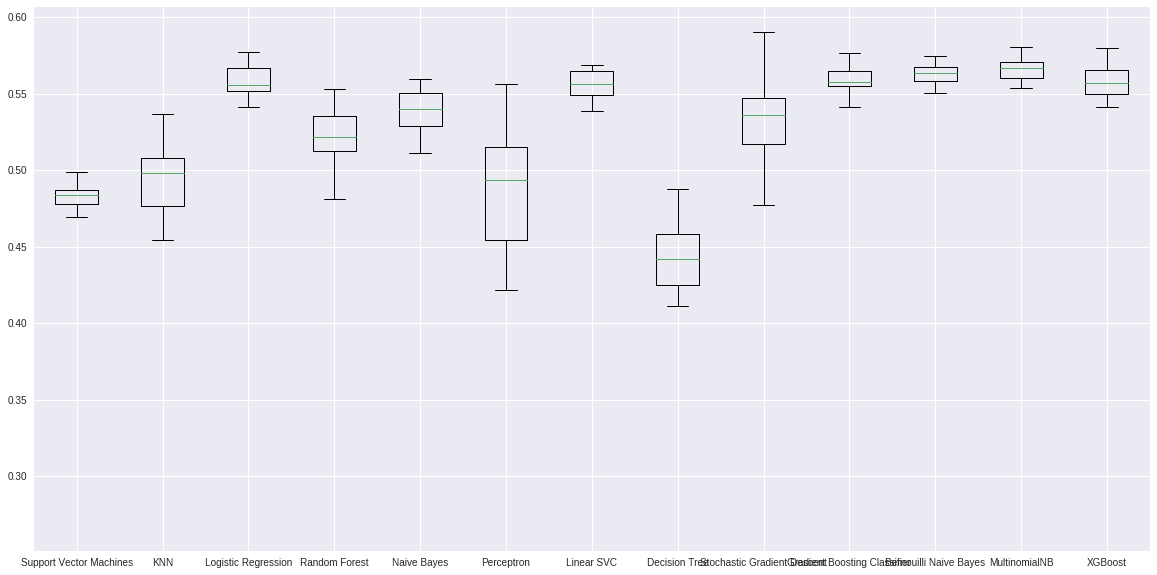

In [52]:
print('Boxplots of the accuracy score achieved for each of the models')

fig, ax = plt.subplots(figsize = (20,10))
plt.boxplot(accuracy[['Accuracy_' + str(i) for i in range(1,20)]])
ax.set_xticklabels(accuracy.index)
plt.show()

### Tuning GradientBoostingClassifier parameters.

We could not implement the Grid search Cross Validation with the XGBoost algorithm. Therefore, we will perform some cross validation with other models and see if we can increase our accuracy.

In [0]:
dataset = obtain_data_representation(df, counter = 'TFIDF', stop_w = my_stop_words)
dataset_em = obtain_data_representation(df, counter = 'TFIDF', emojis = True, stop_w = my_stop_words)

print ('\n')
print ('Full pre-processed training data results size is:', dataset['train']['x'].shape)
print ('Full pre-processed training data with emojis size is:', dataset_em['train']['x'].shape)

print ('---------------------------------------- ')

print ('Full pre-processed testing data results size is: ', dataset['test']['x'].shape)
print ('Full pre-processed testing data with emojis size is: ', dataset_em['test']['x'].shape)


BoW:  {'iberia': 118, 'favor': 98, 'pasajeros': 173, 'demora': 67, 'devolucion': 72, 'dinero': 77, 'paso': 174, 'hace': 107, 'suerte': 215, 'aena': 3, 'problemas': 187, 'pueden': 190, 'hola': 110, 'vuelo': 245, 'hoy': 115, 'anos': 16, 'mas': 145, 'iberiaexpress': 119, 'equipaje': 85, 'mano': 144, 'avion': 25, 'vuelos': 246, 'euros': 95, 'ryanair': 202, 'black': 35, 'friday': 102, 'decir': 65, 'airways': 11, 'gracias': 105, 'retraso': 200, 'compania': 52, 'maleta': 140, 'viajar': 236, 'facturar': 97, 'destino': 70, 'ser': 207, 'low': 134, 'cost': 58, 'vueling': 244, 'peor': 175, 'mejor': 146, 'british': 36, 'pilotos': 177, 'reconocera': 197, 'sindicatos': 212, 'solo': 213, 'inaugura': 122, 'nuevo': 158, 'espacio': 86, 'premium': 183, 'tambien': 216, 'express': 96, 'easyjet': 80, 'aviones': 26, 'tiempo': 221, 'bien': 32, 'cuenta': 61, 'comprar': 54, 'ofertas': 163, 'europa': 93, 'menos': 147, 'pues': 193, 'lanza': 127, 'billetes': 34, 'avios': 27, 'parece': 168, 'parte': 169, 'cambio': 4

In [0]:
fit_params = {
    'n_estimators' : 100,
    'loss': 'deviance',
    'max_features' : None,
    'learning_rate' : 0.1,
    'subsample' : 0.7,
    'criterion' : 'friedman_mse',
    'min_samples_split' : 2,
    'min_samples_leaf' : 1,
    'min_weight_fraction_leaf' : 0.0,
    'max_depth': 3,
    'min_impurity_decrease' : 0.0,
    'min_impurity_split' : None,
    'random_state' : 1234
}

In [0]:
model = GradientBoostingClassifier()
model.set_params(**fit_params)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1234, subsample=0.7, verbose=0,
              warm_start=False)

In [0]:
param_grid = {
    'n_estimators': [1, 10, 50, 100, 200, 500],
}

clf1 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf1.fit(dataset_em['train']['x'], dataset_em['train']['y'])


print("Best parameters found: ", clf1.best_params_)
print("Score error of the best model: ", (clf1.best_score_))

fit_params['n_estimators'] = clf1.best_params_['n_estimators']
model.set_params(**fit_params)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.1min finished


Best parameters found:  {'n_estimators': 100}
Score error of the best model:  0.5530508474576271


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1234, subsample=0.7, verbose=0,
              warm_start=False)

In [0]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
}

clf1 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf1.fit(dataset_em['train']['x'], dataset_em['train']['y'])


print("Best parameters found: ", clf1.best_params_)
print("Score error of the best model: ", (clf1.best_score_))

fit_params['learning_rate'] = clf1.best_params_['learning_rate']
model.set_params(**fit_params)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   44.8s finished


Best parameters found:  {'learning_rate': 0.1}
Score error of the best model:  0.5530508474576271


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1234, subsample=0.7, verbose=0,
              warm_start=False)

In [0]:
param_grid = {
    'max_depth': [2, 3, 5, 10, None],
}


clf1 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf1.fit(dataset_em['train']['x'], dataset_em['train']['y'])


print("Best parameters found: ", clf1.best_params_)
print("Score error of the best model: ", (clf1.best_score_))

fit_params['max_depth'] = clf1.best_params_['max_depth']
model.set_params(**fit_params)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.7min finished


Best parameters found:  {'max_depth': 5}
Score error of the best model:  0.5540677966101695


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1234, subsample=0.7, verbose=0,
              warm_start=False)

In [0]:
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2', None, .5, .75, 1.0],
}


clf1 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf1.fit(dataset_em['train']['x'], dataset_em['train']['y'])


print("Best parameters found: ", clf1.best_params_)
print("Score error of the best model: ", (clf1.best_score_))

fit_params['max_features'] = clf1.best_params_['max_features']
model.set_params(**fit_params)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  1.0min finished


Best parameters found:  {'max_features': 'auto'}
Score error of the best model:  0.5540677966101695


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1234, subsample=0.7, verbose=0,
              warm_start=False)

In [0]:
param_grid = {
    'subsample' : [0.3, 0.5, 0.7, 0.9]
}


clf1 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf1.fit(dataset_em['train']['x'], dataset_em['train']['y'])


print("Best parameters found: ", clf1.best_params_)
print("Score error of the best model: ", (clf1.best_score_))


fit_params['subsample'] = clf1.best_params_['subsample']
model.set_params(**fit_params)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   40.3s finished


Best parameters found:  {'subsample': 0.7}
Score error of the best model:  0.5540677966101695


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1234, subsample=0.7, verbose=0,
              warm_start=False)

In [0]:
final_params = fit_params

gbc = GradientBoostingClassifier()

gbc.set_params(**final_params)
gbc.fit(dataset_em['train']['x'], dataset_em['train']['y'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1234, subsample=0.7, verbose=0,
              warm_start=False)

In [0]:
final_params

'''
final_params = {
 'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'auto',
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'random_state': 1234,
 'subsample': 0.7
 }
'''

"\nfinal_params = {\n 'criterion': 'friedman_mse',\n 'learning_rate': 0.1,\n 'loss': 'deviance',\n 'max_depth': 3,\n 'max_features': 'auto',\n 'min_impurity_decrease': 0.0,\n 'min_impurity_split': None,\n 'min_samples_leaf': 1,\n 'min_samples_split': 2,\n 'min_weight_fraction_leaf': 0.0,\n 'n_estimators': 100,\n 'random_state': 1234,\n 'subsample': 0.7\n }\n"

In [0]:
preds = gbc.predict(dataset_em['test']['x'])
print('Accuracy for the Gradient Boosting Classifier with best parameters found is: %2.6f' % (accuracy_score(dataset_em['test']['y'], preds)))

Accuracy for the Gradient Boosting Classifier with best parameters found is: 0.541434


### XGBoost Grid Search to Optimize parameters without emojis

In [0]:
fit_params = {
    'max_depth' : 6, 
    'learning_rate' : 0.3,
    'n_estimators' : 100, 
    'silent' : True, 
    'objective' : 'multi:softmax',
    'booster' : 'gbtree', 
    'n_jobs' : 1, 
    'gamma' : 0, 
    'min_child_weight' : 1, 
    'max_delta_step' : 0,
    'colsample_bytree': 0.8,
    'subsample': 0.75,
    'colsample_bylevel' : 1, 
    'reg_alpha' : 0, 
    'reg_lambda' : 1, 
    'scale_pos_weight' : 1, 
    'base_score' : 0.5, 
    'random_state' : 0,
}

model = xgb.XGBClassifier() 
model.set_params(**fit_params)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [0]:
print ("paràmetrs inicials: \n", model.set_params(**fit_params))


param_grid = {
    'booster': ['gbtree', 'gblinear', 'dart'],
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset['train']['x'], dataset['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['booster'] = clf2.best_params_['booster']
model.set_params(**fit_params)



param_grid = {
    'n_estimators': [10, 50, 100, 200],
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset['train']['x'], dataset['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['n_estimators'] = clf2.best_params_['n_estimators']
model.set_params(**fit_params)

param_grid = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset['train']['x'], dataset['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['learning_rate'] = clf2.best_params_['learning_rate']
model.set_params(**fit_params)

param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 10, 15],
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset['train']['x'], dataset['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['max_depth'] = clf2.best_params_['max_depth']
model.set_params(**fit_params)

param_grid = {
    'gamma' : [0, 0.1, 0.5, 1, 5]
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset['train']['x'], dataset['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))


fit_params['gamma'] = clf2.best_params_['gamma']
model.set_params(**fit_params)

param_grid = {
    'colsample_bytree': [0.3, 0.6, 0.9],
    'subsample' : [0.3, 0.6, 0.7, 0.9]
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset['train']['x'], dataset['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))


fit_params['colsample_bytree'] = clf2.best_params_['colsample_bytree']
fit_params['subsample'] = clf2.best_params_['subsample']
model.set_params(**fit_params)

param_grid = {
    'reg_lambda': [0.1, 1, 10],
    'reg_alpha' : [0, 0.1, 1]
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset['train']['x'], dataset['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['reg_lambda'] = clf2.best_params_['reg_lambda']
fit_params['reg_alpha'] = clf2.best_params_['reg_alpha']
model.set_params(**fit_params)

final_params_xgb = fit_params.copy()
try:
  final_params_xgb.pop('num_class')
except:
  pass


#final_params_xgb = fit_params
print("paràmetres finals:\n", final_params_xgb) 
print ("paràmetrs finals: \n", model.set_params(**fit_params))

paràmetrs inicials: 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)
Fitting 4 folds for each of 3 candidates, totalling 12 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'booster': 'gblinear'}
Score error of the best model:  0.5510169491525424
Fitting 4 folds for each of 4 candidates, totalling 16 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'n_estimators': 100}
Score error of the best model:  0.5510169491525424
Fitting 4 folds for each of 4 candidates, totalling 16 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'learning_rate': 0.3}
Score error of the best model:  0.5510169491525424
Fitting 4 folds for each of 7 candidates, totalling 28 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'max_depth': 2}
Score error of the best model:  0.5510169491525424
Fitting 4 folds for each of 5 candidates, totalling 20 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'gamma': 0}
Score error of the best model:  0.5510169491525424
Fitting 4 folds for each of 12 candidates, totalling 48 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'colsample_bytree': 0.3, 'subsample': 0.3}
Score error of the best model:  0.5510169491525424
Fitting 4 folds for each of 9 candidates, totalling 36 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'reg_alpha': 1, 'reg_lambda': 1}
Score error of the best model:  0.5574576271186441
paràmetres finals:
 {'max_depth': 2, 'learning_rate': 0.3, 'n_estimators': 100, 'silent': True, 'objective': 'multi:softmax', 'booster': 'gblinear', 'n_jobs': 1, 'gamma': 0, 'min_child_weight': 1, 'max_delta_step': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'colsample_bylevel': 1, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'base_score': 0.5, 'random_state': 0}
paràmetrs finals: 
 XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.3)


In [0]:
#final_params_xgb2= {'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 50, 'silent': True, 'objective': 'multi:softmax', 'booster': 'gblinear', 'n_jobs': 1, 'gamma': 0, 'min_child_weight': 1, 'max_delta_step': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'colsample_bylevel': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'base_score': 0.5, 'random_state': 0}
model1 = xgb.XGBClassifier(**final_params_xgb)

print ("final_params_xgb: ", final_params_xgb)

model1.fit(dataset['train']['x'], dataset['train']['y'])
preds = model1.predict(dataset['test']['x'])
print('SENSE EMOJIS:Accuracy for the XGBClassifier with best parameters found is: %2.6f' % (accuracy_score(dataset['test']['y'], preds)))

model1.fit(dataset['train']['x'], dataset['train']['y'])

final_params_xgb:  {'max_depth': 2, 'learning_rate': 0.3, 'n_estimators': 100, 'silent': True, 'objective': 'multi:softmax', 'booster': 'gblinear', 'n_jobs': 1, 'gamma': 0, 'min_child_weight': 1, 'max_delta_step': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'colsample_bylevel': 1, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'base_score': 0.5, 'random_state': 0}
SENSE EMOJIS:Accuracy for the XGBClassifier with best parameters found is: 0.577529


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.3)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy for the XGB, sense EMOJI, with best parameters found is: 0.577529
Confusion Matrix for BXG with emojis 

[[0.61 0.26 0.12]
 [0.22 0.48 0.29]
 [0.15 0.33 0.51]]


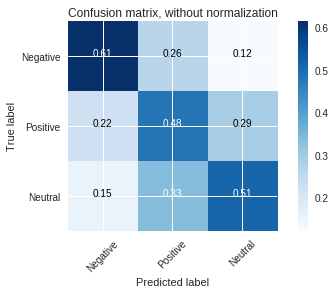

In [0]:
model1 = xgb.XGBClassifier()


model1.set_params(**final_params_xgb)

model1.fit(dataset['train']['x'], dataset['train']['y'])
pred1=model1.predict(dataset['test']['x'])

print('Accuracy for the XGB, sense EMOJI, with best parameters found is: %2.6f' % (accuracy_score(dataset['test']['y'], pred1)))


print ('Confusion Matrix for BXG with emojis \n')
cnf_matrix1 = confusion_matrix(pred1, dataset['test']['y'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()


### XGBoost Grid Search to Optimize parameters w/ emojis

In [0]:
fit_params = {
    'max_depth' : 6, 
    'learning_rate' : 0.3,
    'n_estimators' : 100, 
    'silent' : True, 
    'objective' : 'multi:softmax',
    'booster' : 'gbtree', 
    'n_jobs' : 1, 
    'gamma' : 0, 
    'min_child_weight' : 1, 
    'max_delta_step' : 0,
    'colsample_bytree': 0.8,
    'subsample': 0.99,
    'colsample_bylevel' : 1, 
    'reg_alpha' : 0, 
    'reg_lambda' : 1, 
    'scale_pos_weight' : 1, 
    'base_score' : 0.5, 
    'random_state' : 0,
}

model = xgb.XGBClassifier() 
model.set_params(**fit_params)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.99)

In [0]:
print ("paràmetrs inicials: \n", model.set_params(**fit_params))


param_grid = {
    'booster': ['gbtree', 'gblinear', 'dart'],
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_em['train']['x'], dataset_em['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['booster'] = clf2.best_params_['booster']
model.set_params(**fit_params)



param_grid = {
    'n_estimators': [10, 50, 100, 200],
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_em['train']['x'], dataset_em['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['n_estimators'] = clf2.best_params_['n_estimators']
model.set_params(**fit_params)

param_grid = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_em['train']['x'], dataset_em['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['learning_rate'] = clf2.best_params_['learning_rate']
model.set_params(**fit_params)

param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 10, 15],
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_em['train']['x'], dataset_em['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['max_depth'] = clf2.best_params_['max_depth']
model.set_params(**fit_params)

param_grid = {
    'gamma' : [0, 0.1, 0.5, 1, 5]
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_em['train']['x'], dataset_em['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))


fit_params['gamma'] = clf2.best_params_['gamma']
model.set_params(**fit_params)

param_grid = {
    'colsample_bytree': [0.3, 0.6, 0.9],
    'subsample' : [0.3, 0.6, 0.7, 0.9]
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_em['train']['x'], dataset_em['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))


fit_params['colsample_bytree'] = clf2.best_params_['colsample_bytree']
fit_params['subsample'] = clf2.best_params_['subsample']
model.set_params(**fit_params)

param_grid = {
    'reg_lambda': [0.1, 1, 10],
    'reg_alpha' : [0, 0.1, 1]
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_em['train']['x'], dataset_em['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['reg_lambda'] = clf2.best_params_['reg_lambda']
fit_params['reg_alpha'] = clf2.best_params_['reg_alpha']
model.set_params(**fit_params)

final_params_xgb = fit_params.copy()
try:
  final_params_xgb.pop('num_class')
except:
  pass


#final_params_xgb = fit_params
print("paràmetres finals:\n", final_params_xgb) 
print ("paràmetrs finals: \n", model.set_params(**fit_params))

paràmetrs inicials: 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.99)
Fitting 4 folds for each of 3 candidates, totalling 12 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'booster': 'gblinear'}
Score error of the best model:  0.5559322033898305
Fitting 4 folds for each of 4 candidates, totalling 16 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'n_estimators': 100}
Score error of the best model:  0.5559322033898305
Fitting 4 folds for each of 4 candidates, totalling 16 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'learning_rate': 0.05}
Score error of the best model:  0.556271186440678
Fitting 4 folds for each of 7 candidates, totalling 28 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'max_depth': 2}
Score error of the best model:  0.556271186440678
Fitting 4 folds for each of 5 candidates, totalling 20 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'gamma': 0}
Score error of the best model:  0.556271186440678
Fitting 4 folds for each of 12 candidates, totalling 48 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'colsample_bytree': 0.3, 'subsample': 0.3}
Score error of the best model:  0.556271186440678
Fitting 4 folds for each of 9 candidates, totalling 36 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'reg_alpha': 1, 'reg_lambda': 1}
Score error of the best model:  0.5576271186440678
paràmetres finals:
 {'max_depth': 2, 'learning_rate': 0.05, 'n_estimators': 100, 'silent': True, 'objective': 'multi:softmax', 'booster': 'gblinear', 'n_jobs': 1, 'gamma': 0, 'min_child_weight': 1, 'max_delta_step': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'colsample_bylevel': 1, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'base_score': 0.5, 'random_state': 0}
paràmetrs finals: 
 XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.3)


In [0]:
#final_params_xgb2= {'max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 50, 'silent': True, 'objective': 'multi:softmax', 'booster': 'gblinear', 'n_jobs': 1, 'gamma': 0, 'min_child_weight': 1, 'max_delta_step': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'colsample_bylevel': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'base_score': 0.5, 'random_state': 0}
model1 = xgb.XGBClassifier(**final_params_xgb)

print ("final_params_xgb: ", final_params_xgb)

model1.fit(dataset_em['train']['x'], dataset_em['train']['y'])
preds = model1.predict(dataset_em['test']['x'])
print('EMOJIS:Accuracy for the XGBClassifier with best parameters found is: %2.6f' % (accuracy_score(dataset_em['test']['y'], preds)))

model1.fit(dataset_em['train']['x'], dataset_em['train']['y'])

final_params_xgb:  {'max_depth': 2, 'learning_rate': 0.05, 'n_estimators': 100, 'silent': True, 'objective': 'multi:softmax', 'booster': 'gblinear', 'n_jobs': 1, 'gamma': 0, 'min_child_weight': 1, 'max_delta_step': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'colsample_bylevel': 1, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'base_score': 0.5, 'random_state': 0}
EMOJIS:Accuracy for the XGBClassifier with best parameters found is: 0.563294


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.3)

In [0]:
final_params_xgb = fit_params.copy()
try:
  final_params_xgb.pop('num_class')
except:
  pass
#final_params_xgb = fit_params
print(final_params_xgb) 

{'max_depth': 2, 'learning_rate': 0.05, 'n_estimators': 100, 'silent': True, 'objective': 'multi:softmax', 'booster': 'gblinear', 'n_jobs': 1, 'gamma': 0, 'min_child_weight': 1, 'max_delta_step': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'colsample_bylevel': 1, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'base_score': 0.5, 'random_state': 0}


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy for the XGB, amb EMOJI, with best parameters found is: 0.563294
Confusion Matrix for BXG with emojis 

[[0.62 0.26 0.12]
 [0.31 0.47 0.22]
 [0.16 0.37 0.48]]


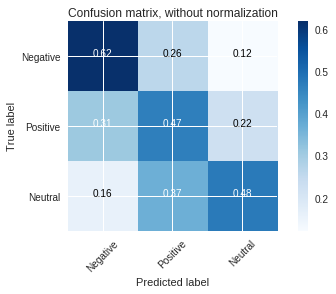

In [0]:
model1 = xgb.XGBClassifier()


model1.set_params(**final_params_xgb)

model1.fit(dataset_em['train']['x'], dataset_em['train']['y'])
pred1=model1.predict(dataset_em['test']['x'])

print('Accuracy for the XGB, amb EMOJI, with best parameters found is: %2.6f' % (accuracy_score(dataset_em['test']['y'], pred1)))


print ('Confusion Matrix for BXG with emojis \n')
cnf_matrix1 = confusion_matrix(pred1, dataset_em['test']['y'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['Negative','Positive','Neutral'],
                      title='Confusion matrix, without normalization')
plt.show()






### XGBoost Grid Search to Optimize parameters w/ emojis  and bigrams

In [0]:
fit_params = {
    'max_depth' : 6, 
    'learning_rate' : 0.3,
    'n_estimators' : 100, 
    'silent' : True, 
    'objective' : 'multi:softmax',
    'booster' : 'gbtree', 
    'n_jobs' : 1, 
    'gamma' : 0, 
    'min_child_weight' : 1, 
    'max_delta_step' : 0,
    'colsample_bytree': 0.8,
    'subsample': 0.75,
    'colsample_bylevel' : 1, 
    'reg_alpha' : 0, 
    'reg_lambda' : 1, 
    'scale_pos_weight' : 1, 
    'base_score' : 0.5, 
    'random_state' : 0,
}

model = xgb.XGBClassifier() 
model.set_params(**fit_params)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [0]:

print ("paràmetrs inicials: \n", model.set_params(**fit_params))

#BOOSTER
param_grid = {
    'booster': ['gbtree', 'gblinear', 'dart'],
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_bigrams['train']['x'], dataset_bigrams['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))


fit_params['booster'] = clf2.best_params_['booster']
model.set_params(**fit_params)


#n_estimators
param_grid = {
    'n_estimators': [10, 50, 100, 200],
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_bigrams['train']['x'], dataset_bigrams['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['n_estimators'] = clf2.best_params_['n_estimators']
model.set_params(**fit_params)


param_grid = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_bigrams['train']['x'], dataset_bigrams['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['learning_rate'] = clf2.best_params_['learning_rate']
model.set_params(**fit_params)

param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 10, 15],
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_em['train']['x'], dataset_em['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['max_depth'] = clf2.best_params_['max_depth']
model.set_params(**fit_params)

param_grid = {
    'gamma' : [0, 0.1, 0.5, 1, 5]
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_bigrams['train']['x'], dataset_bigrams['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))


fit_params['gamma'] = clf2.best_params_['gamma']
model.set_params(**fit_params)

param_grid = {
    'colsample_bytree': [0.3, 0.6, 0.9],
    'subsample' : [0.3, 0.6, 0.7, 0.9]
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_bigrams['train']['x'], dataset_bigrams['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))


fit_params['colsample_bytree'] = clf2.best_params_['colsample_bytree']
fit_params['subsample'] = clf2.best_params_['subsample']
model.set_params(**fit_params)

param_grid = {
    'reg_lambda': [0.1, 1, 10],
    'reg_alpha' : [0, 0.1, 1]
}


clf2 = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=4, verbose=1)

clf2.fit(dataset_bigrams['train']['x'], dataset_bigrams['train']['y'])


print("Best parameters found: ", clf2.best_params_)
print("Score error of the best model: ", (clf2.best_score_))

fit_params['reg_lambda'] = clf2.best_params_['reg_lambda']
fit_params['reg_alpha'] = clf2.best_params_['reg_alpha']
model.set_params(**fit_params)

final_params_xgb = fit_params.copy()
try:
  final_params_xgb.pop('num_class')
except:
  pass
#final_params_xgb = fit_params
print(final_params_xgb) 
print ("paràmetrs finals: \n", model.set_params(**fit_params))

paràmetrs inicials: 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)
Fitting 4 folds for each of 3 candidates, totalling 12 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'booster': 'dart'}
Score error of the best model:  0.5547457627118644
Fitting 4 folds for each of 4 candidates, totalling 16 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'n_estimators': 100}
Score error of the best model:  0.5547457627118644
Fitting 4 folds for each of 4 candidates, totalling 16 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'learning_rate': 0.2}
Score error of the best model:  0.5586440677966101
Fitting 4 folds for each of 7 candidates, totalling 28 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  2.4min finished


Best parameters found:  {'max_depth': 5}
Score error of the best model:  0.5547457627118644
Fitting 4 folds for each of 5 candidates, totalling 20 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'gamma': 1}
Score error of the best model:  0.558135593220339
Fitting 4 folds for each of 12 candidates, totalling 48 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'colsample_bytree': 0.6, 'subsample': 0.7}
Score error of the best model:  0.5561016949152542
Fitting 4 folds for each of 9 candidates, totalling 36 fits


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Best parameters found:  {'reg_alpha': 0.1, 'reg_lambda': 1}
Score error of the best model:  0.5571186440677967
{'max_depth': 5, 'learning_rate': 0.2, 'n_estimators': 100, 'silent': True, 'objective': 'multi:softmax', 'booster': 'dart', 'n_jobs': 1, 'gamma': 1, 'min_child_weight': 1, 'max_delta_step': 0, 'colsample_bytree': 0.6, 'subsample': 0.7, 'colsample_bylevel': 1, 'reg_alpha': 0.1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'base_score': 0.5, 'random_state': 0}
paràmetrs finals: 
 XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)


final_params_xgb:  {'max_depth': 5, 'learning_rate': 0.2, 'n_estimators': 100, 'silent': True, 'objective': 'multi:softmax', 'booster': 'dart', 'n_jobs': 1, 'gamma': 1, 'min_child_weight': 1, 'max_delta_step': 0, 'colsample_bytree': 0.6, 'subsample': 0.7, 'colsample_bylevel': 1, 'reg_alpha': 0.1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'base_score': 0.5, 'random_state': 0}


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy for the XGBClassifier with best parameters found is: 0.559227
Confusion Matrix for XGB with biagrams 

[[0.64 0.24 0.11]
 [0.34 0.44 0.22]
 [0.21 0.34 0.45]]


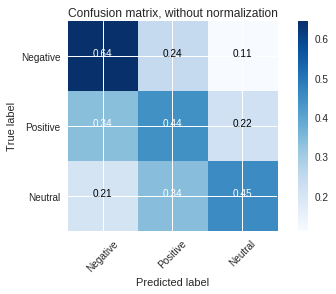

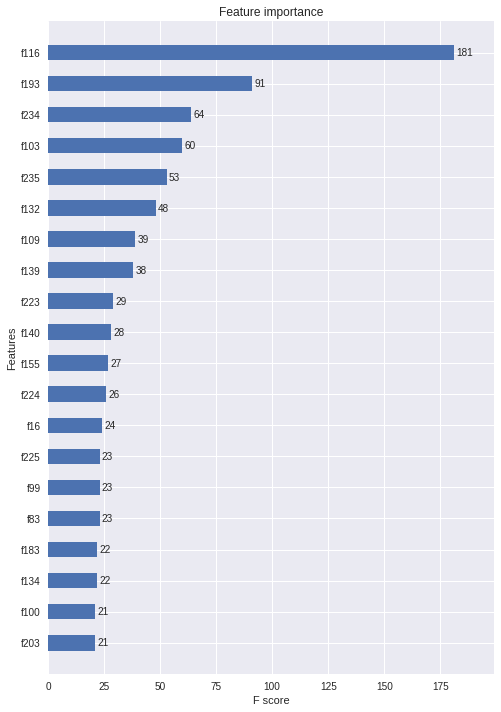

In [0]:
'''final_params_xgb = {
    'max_depth' : 6, 
    'learning_rate' : 0.3,
    'n_estimators' : 100, 
    'silent' : True, 
    'objective' : 'multi:softmax',
    'booster' : 'gbtree', 
    'n_jobs' : 1, 
    'gamma' : 0, 
    'min_child_weight' : 1, 
    'max_delta_step' : 0,
    'colsample_bytree': 0.8,
    'subsample': 0.75,
    'colsample_bylevel' : 1, 
    'reg_alpha' : 0, 
    'reg_lambda' : 1, 
    'scale_pos_weight' : 1, 
    'base_score' : 0.5, 
    'random_state' : 0,
}'''
print ("final_params_xgb: ", final_params_xgb)

model = xgb.XGBClassifier(**final_params_xgb)
model.fit(dataset_bigrams['train']['x'], dataset_bigrams['train']['y'])
preds = model.predict(dataset_bigrams['test']['x'])
print('Accuracy for the XGBClassifier with best parameters found is: %2.6f' % (accuracy_score(dataset_bigrams['test']['y'], preds)))

print ('Confusion Matrix for XGB with biagrams \n')
cnf_matrix1 = confusion_matrix(preds, dataset_bigrams['test']['y'])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['Negative','Positive','Neutral'],title='Confusion matrix, without normalization')
plt.show()

ifg, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(model, height=0.5, ax=ax, max_num_features = 20)
plt.show()



## 8. Make Predictions

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'1cdoOwwh5HEuPTwOiKkASvLHw1kGf9VY-'}) # replace the id with id of file you want to access
downloaded.GetContentFile('tweets_submission_spanish.csv')  

df_submission = pd.read_csv('tweets_submission_spanish.csv', index_col = 'tweet_id')
df_submission.head()

,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,
942273491440631808,True,0,0,@Iberia Está clara vuestra política de rascar ...,NaN,Sun Dec 17 06:01:21 +0000 2017,NaN,NaN
943008475608682502,False,0,0,Iberia Plus cumple 25 años. Queremos celebrarl...,NaN,Tue Dec 19 06:41:55 +0000 2017,NaN,NaN
931226872729530368,False,0,0,"A ver, @Iberia, de verdad. Lo vuestro con el ...",NaN,Thu Nov 16 18:26:02 +0000 2017,NaN,Madrid
933782711600283650,False,0,0,".@JavierJover, head of partnership and SMBs en...",NaN,Thu Nov 23 19:42:01 +0000 2017,NaN,Madrid
941987812534038529,False,0,0,"Faro, Portugal 🇵🇹🤓✈️ https://t.co/Obzj8YlXTL",NaN,Sat Dec 16 11:06:10 +0000 2017,NaN,Hawaii


In [0]:

df_submission['text'] = df_submission.apply(lambda x: remove_links(x.text), axis = 1)
df_submission['emojis'] = df_submission.apply(lambda x: capture_emojis(x.text), axis = 1)
# We use df_submision as test, otherwise it would split df in train/test
submission_dataset = obtain_data_representation(df, df_submission, emojis = True)

model.fit(submission_dataset['train']['x'], submission_dataset['train']['y'])

print ('The shape of the testing dataset is: (%i, %i)' % (df_submission.shape), '\n')

print(submission_dataset)
predictions = model.predict(submission_dataset['test']['x'])
# Create submission file with obtained y_pred
create_submit_file(df_submission, predictions)

BoW:  {'los': 154, 'pilotos': 208, 'ryanair': 238, 'huelga': 137, 'tras': 269, 'ver': 280, 'sus': 256, 'sindicatos': 250, 'pais': 196, 'via': 284, 'noticias': 183, 'iberia': 139, 'por': 214, 'favor': 115, 'las': 148, 'entre': 92, 'no': 181, 'pueden': 224, 'una': 273, 'que': 228, 'tiene': 264, 'mas': 166, 'con': 58, 'eso': 97, 'avianca': 26, 'verdad': 281, 'paso': 204, 'dos': 85, 'veces': 279, 'esa': 95, 'aerolinea': 4, 'hola': 131, 'numero': 187, 'plus': 209, 'ellos': 88, 'tengo': 262, 'gracias': 123, 'video': 288, 'accidente': 1, 'spanair': 254, 'barajas': 31, 'espana': 99, 'destino': 76, 'solo': 252, 'click': 51, 'deseadme': 74, 'suerte': 255, 'holacolombia': 133, 'destinos': 77, 'europeos': 111, 'mejor': 167, 'precio': 216, 'maleta': 161, 'nada': 177, 'telefono': 260, 'reclamacion': 232, 'para': 197, 'menos': 168, 'mal': 159, 'hacer': 126, 'poco': 210, 'todos': 268, 'despues': 75, 'dia': 78, 'navidad': 179, 'van': 278, 'ruta': 237, 'reconocera': 233, 'primera': 219, 'vez': 283, 'est

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Submission file created: submission_06_26_2018.csv
Upload it to Kaggle InClass
